<img src="https://www.freewebheaders.com/wp-content/gallery/aircrafts/cache/float-air-force-header-3919.jpg-nggid041839-ngg0dyn-1280x375x100-00f0w010c010r110f110r010t010.jpg">


# <center> **Army Aircraft Detection using Pre-train Models and AutoEncoders!** </center>

In [31]:
#Librarys
import kagglehub
import tensorflow as tf
import os

from setuptools.namespaces import flatten
from sklearn.model_selection import train_test_split
import kagglehub
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import random
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np 
import datetime
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from sklearn.metrics import confusion_matrix, classification_report

# Download latest version dataset
path = kagglehub.dataset_download("a2015003713/militaryaircraftdetectiondataset")
print("Path to dataset files:", path)

Path to dataset files: /Users/daniel/.cache/kagglehub/datasets/a2015003713/militaryaircraftdetectiondataset/versions/81


In [32]:
#Leer Datasets
data_dir = "/Users/daniel/.cache/kagglehub/datasets/a2015003713/militaryaircraftdetectiondataset/versions/80/crop"

filepaths = []
labels = []

folds = [fold for fold in os.listdir(data_dir) if not fold.startswith('.')]

for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    if os.path.isdir(foldpath):
        files = [f for f in os.listdir(foldpath) if not f.startswith('.')]  # Filtrar archivos ocultos
        for f in files:
            fpath = os.path.join(foldpath, f)
            
            filepaths.append(fpath)
            labels.append(fold)

data_dir = pd.DataFrame(data={'filepaths': filepaths, 'labels': labels})

print("Imágenes en total: ", len(data_dir))
print("Clases en total: ", data_dir['labels'].nunique())

Imágenes en total:  31917
Clases en total:  74


/var/folders/1g/80fc1ztj24179l9s1klghxjr0000gn/T/ipykernel_2784/2880767316.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="labels", data=data_dir, order=order, palette=colors)  # Añadir 'order=order' para ordenar


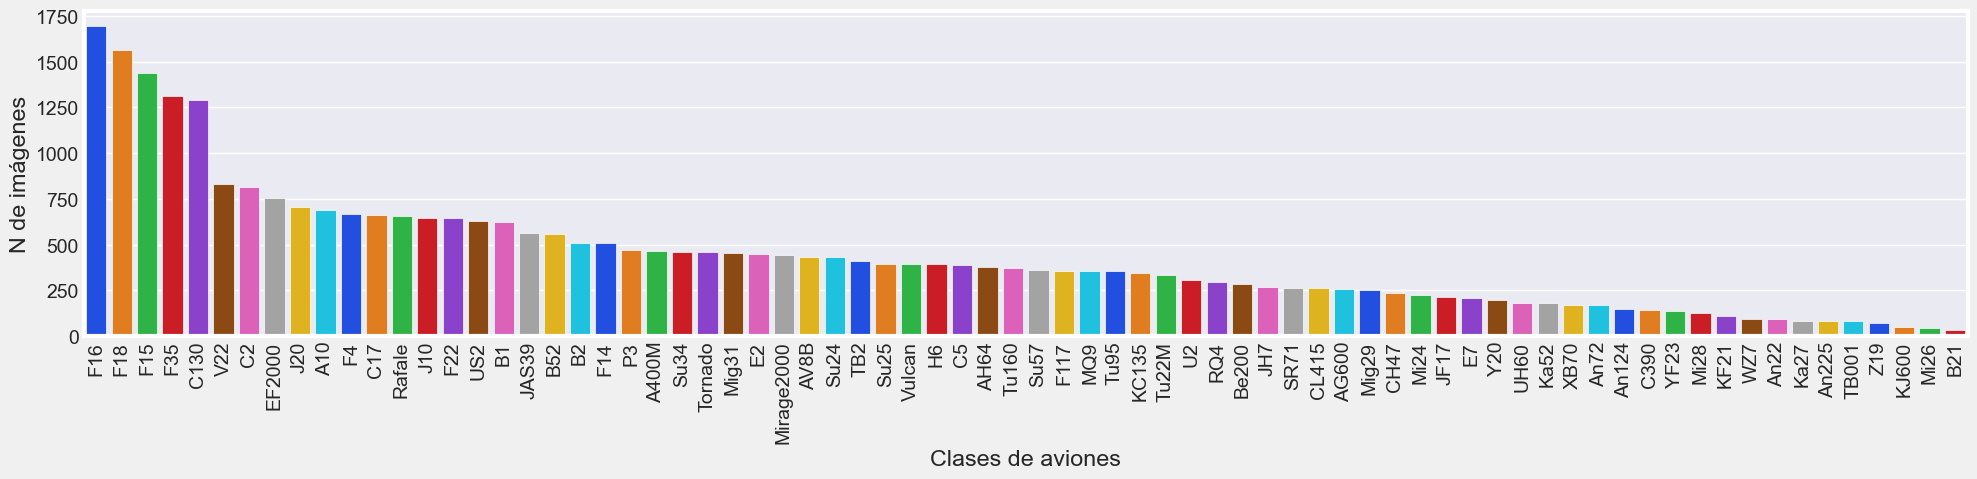

In [33]:


order = data_dir['labels'].value_counts().index

plt.figure(figsize=(20, 5))
sns.set_style("darkgrid")
colors = sns.color_palette("bright", len(order))  # Generar una paleta de colores
sns.countplot(x="labels", data=data_dir, order=order, palette=colors)  # Añadir 'order=order' para ordenar
plt.xlabel("Clases de aviones")
plt.ylabel("N de imágenes")  # Cambiar etiqueta del eje Y
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig(f"dataset_complete.png")
plt.show()



In [34]:
# Elegir solo los que tengan mas de 1000 imagenes
label_counts = data_dir['labels'].value_counts()
data_dir = data_dir[data_dir['labels'].isin(label_counts[label_counts >= 1000].index)]

/var/folders/1g/80fc1ztj24179l9s1klghxjr0000gn/T/ipykernel_2784/2139374671.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="labels", data=data_dir, order=order, palette=colors)  # Añadir 'order=order' para ordenar


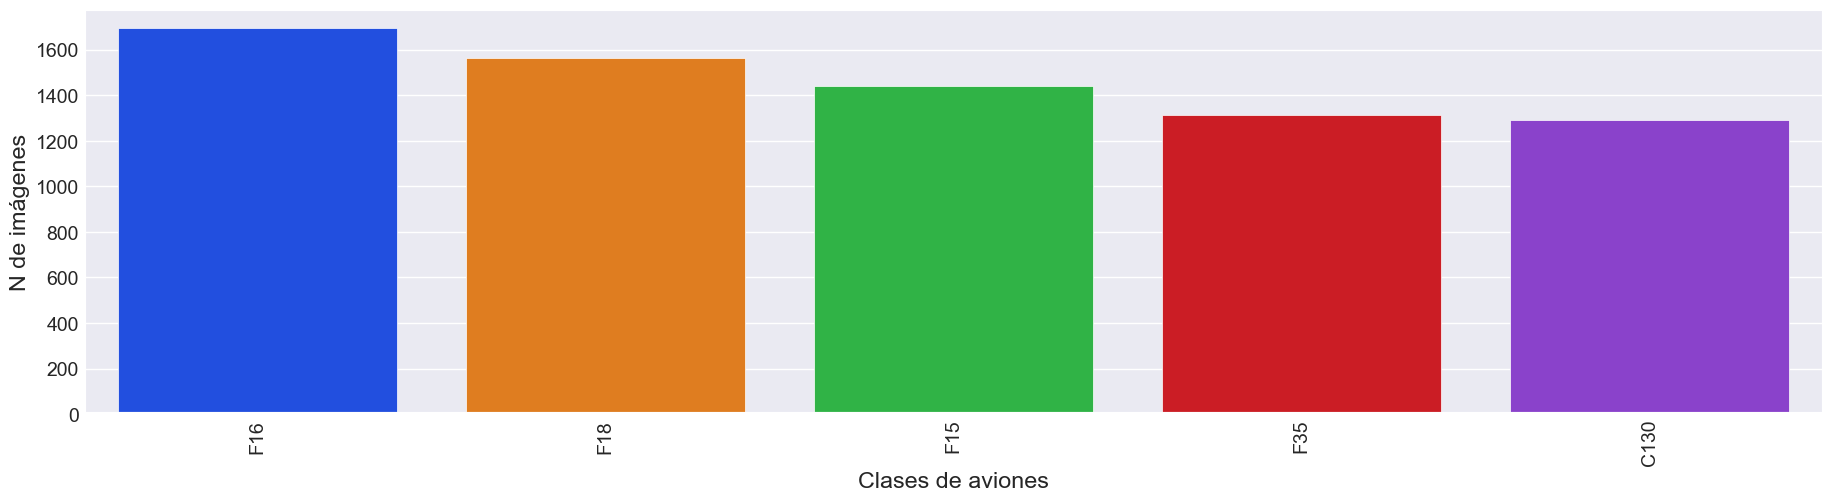

In [35]:
order = data_dir['labels'].value_counts().index

plt.figure(figsize=(20, 5))
sns.set_style("darkgrid")
colors = sns.color_palette("bright", len(order))  # Generar una paleta de colores
sns.countplot(x="labels", data=data_dir, order=order, palette=colors)  # Añadir 'order=order' para ordenar
plt.xlabel("Clases de aviones")
plt.ylabel("N de imágenes")  # Cambiar etiqueta del eje Y
plt.xticks(rotation=90)
plt.savefig(f"dataset_short.png")
plt.show()

In [36]:
train_df , test_df = train_test_split(data_dir, test_size= 0.2, shuffle= True, random_state= 42)

In [37]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

n_classes = data_dir['labels'].nunique()

# Generador de entrenamiento
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepaths', 
    y_col='labels', 
    target_size=(32, 32),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=128,
    subset="training"
)


# Generador de prueba (test)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepaths',
    y_col='labels',
    target_size=(32, 32),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=128
)

Found 5840 validated image filenames belonging to 5 classes.
Found 1461 validated image filenames belonging to 5 classes.


# <center> **Funciones de graficas** </center>

In [38]:
#Visualizar 5 aviones por label
def plot_images_by_label(generator, unique_labels, num_images=5):
    """
    Muestra un número específico de imágenes por etiqueta usando un generador de datos.
    Args:
        generator: Generador de datos con imágenes y etiquetas.
        unique_labels: Lista de etiquetas únicas.
        num_images: Número de imágenes a mostrar por etiqueta.
    """
    # Crear una figura con subplots
    fig, axes = plt.subplots(len(unique_labels), num_images, figsize=(num_images * 3, len(unique_labels) * 3))

    # Iterar sobre las etiquetas únicas
    for i, label in enumerate(unique_labels):
        images_for_label = []

        while len(images_for_label) < num_images:
            images, labels = next(generator)
            for img, lbl in zip(images, labels):
                if np.argmax(lbl) == label:
                    images_for_label.append(img)
                    if len(images_for_label) == num_images:
                        break

        # Mostrar las imágenes en los subplots
        for j in range(num_images):
            axes[i, j].imshow(images_for_label[j])

        # Etiquetar la fila con el nombre de la etiqueta
        axes[i, 0].set_ylabel(f"Label: {label}", size=15)

    plt.tight_layout()
    plt.savefig(f"Ejemplo de images.png")
    plt.show()


#Visualizar resultados
def plot_training_history(history, save_path):
    """
    Grafica la pérdida y las métricas (Accuracy, AUC, Precision, Recall) de entrenamiento y validación de un modelo.

    Args:
        history: Objeto `History` devuelto por el método `fit` de Keras.
        save_path: Ruta para guardar las gráficas generadas.
    """
    # Extraer métricas de entrenamiento y validación
    tr_loss = history.history['loss']
    val_loss = history.history['val_loss']
    tr_acc = history.history.get('accuracy', [])
    val_acc = history.history.get('val_accuracy', [])
    tr_auc = history.history.get('auc', [])
    val_auc = history.history.get('val_auc', [])
    tr_precision = history.history.get('precision', [])
    val_precision = history.history.get('val_precision', [])
    tr_recall = history.history.get('recall', [])
    val_recall = history.history.get('val_recall', [])

    # Crear lista de épocas
    epochs = [i + 1 for i in range(len(tr_loss))]

    plt.figure(figsize=(20, 8))
    plt.style.use('fivethirtyeight')

    # Gráfica 1: Pérdida
    plt.subplot(1, 2, 1)
    plt.plot(epochs, tr_loss, 'orange', label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Gráfica 2: Métricas combinadas
    plt.subplot(1, 2, 2)
    if tr_acc and val_acc:
        plt.plot(epochs, tr_acc, 'darkblue', label='Training Accuracy')
        plt.plot(epochs, val_acc, 'blue', label='Validation Accuracy')
    if tr_auc and val_auc:
        plt.plot(epochs, tr_auc, 'darkgreen', label='Training AUC')
        plt.plot(epochs, val_auc, 'lime', label='Validation AUC')
    if tr_precision and val_precision:
        plt.plot(epochs, tr_precision, 'purple', label='Training Precision')
        plt.plot(epochs, val_precision, 'violet', label='Validation Precision')
    if tr_recall and val_recall:
        plt.plot(epochs, tr_recall, 'darkred', label='Training Recall')
        plt.plot(epochs, val_recall, 'red', label='Validation Recall')

    plt.title('Training and Validation Metrics')
    plt.xlabel('Epochs')
    plt.ylabel('Value')
    plt.legend()

    plt.tight_layout()
    plt.savefig(f"training_history_{save_path}.png")
    plt.show()




#Resultados de todos los modelos
def plot_model_metrics(all_metrics, metric_name):
    """
    Graficar una métrica específica para diferentes modelos.
    Args:
        all_metrics: Diccionario con las métricas de todos los modelos.
        metric_name: Nombre de la métrica a graficar (e.g., 'accuracy', 'loss').
    """
    plt.figure(figsize=(10, 6))

    for model_name, metrics in all_metrics.items():
        plt.plot(metrics[metric_name], label=f'{model_name} - {metric_name}')
        if f'val_{metric_name}' in metrics:
            plt.plot(metrics[f'val_{metric_name}'], label=f'{model_name} - val_{metric_name}', linestyle='--')

    plt.title(f'Comparison of {metric_name}')
    plt.xlabel('Epochs')
    plt.ylabel(metric_name.capitalize())
    plt.legend()
    plt.grid(True)
    plt.savefig(f"models_metrics.png")
    plt.show()


#Matrices de confusion

def plot_confusion_matrix_and_classification_report(y_true, y_pred, class_names, save_path):
    """
    Esta función genera y guarda la matriz de confusión y el reporte de clasificación desde un notebook.

    Parameters:
    y_true (array-like): Etiquetas verdaderas del conjunto de datos
    y_pred (array-like): Predicciones del modelo
    class_names (list): Lista de nombres de las clases
    save_path (str): Prefijo de los archivos a guardar (sin extensión)

    Returns:
    None
    """
    # Generar la matriz de confusión
    conf_matrix = confusion_matrix(y_true, y_pred)

    # Graficar la matriz de confusión
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', xticklabels=class_names, yticklabels=class_names)
    plt.title('Matriz de Confusión')
    plt.xlabel('Predicciones')
    plt.ylabel('Verdaderas Etiquetas')
    plt.tight_layout()

    # Guardar la matriz de confusión como imagen
    matrix_path = f"{save_path}_confusion_matrix.png"
    plt.savefig(matrix_path)
    print(f"Matriz de confusión guardada en: {matrix_path}")

    # Mostrar la matriz de confusión en el notebook
    plt.show()

    # Generar y mostrar el reporte de clasificación
    report = classification_report(y_true, y_pred, target_names=class_names)
    print("Reporte de Clasificación:")
    print(report)

    # Guardar el reporte de clasificación como un archivo de texto
    report_path = f"{save_path}_classification_report.txt"
    with open(report_path, "w") as f:
        f.write(report)
    print(f"Reporte de clasificación guardado en: {report_path}")


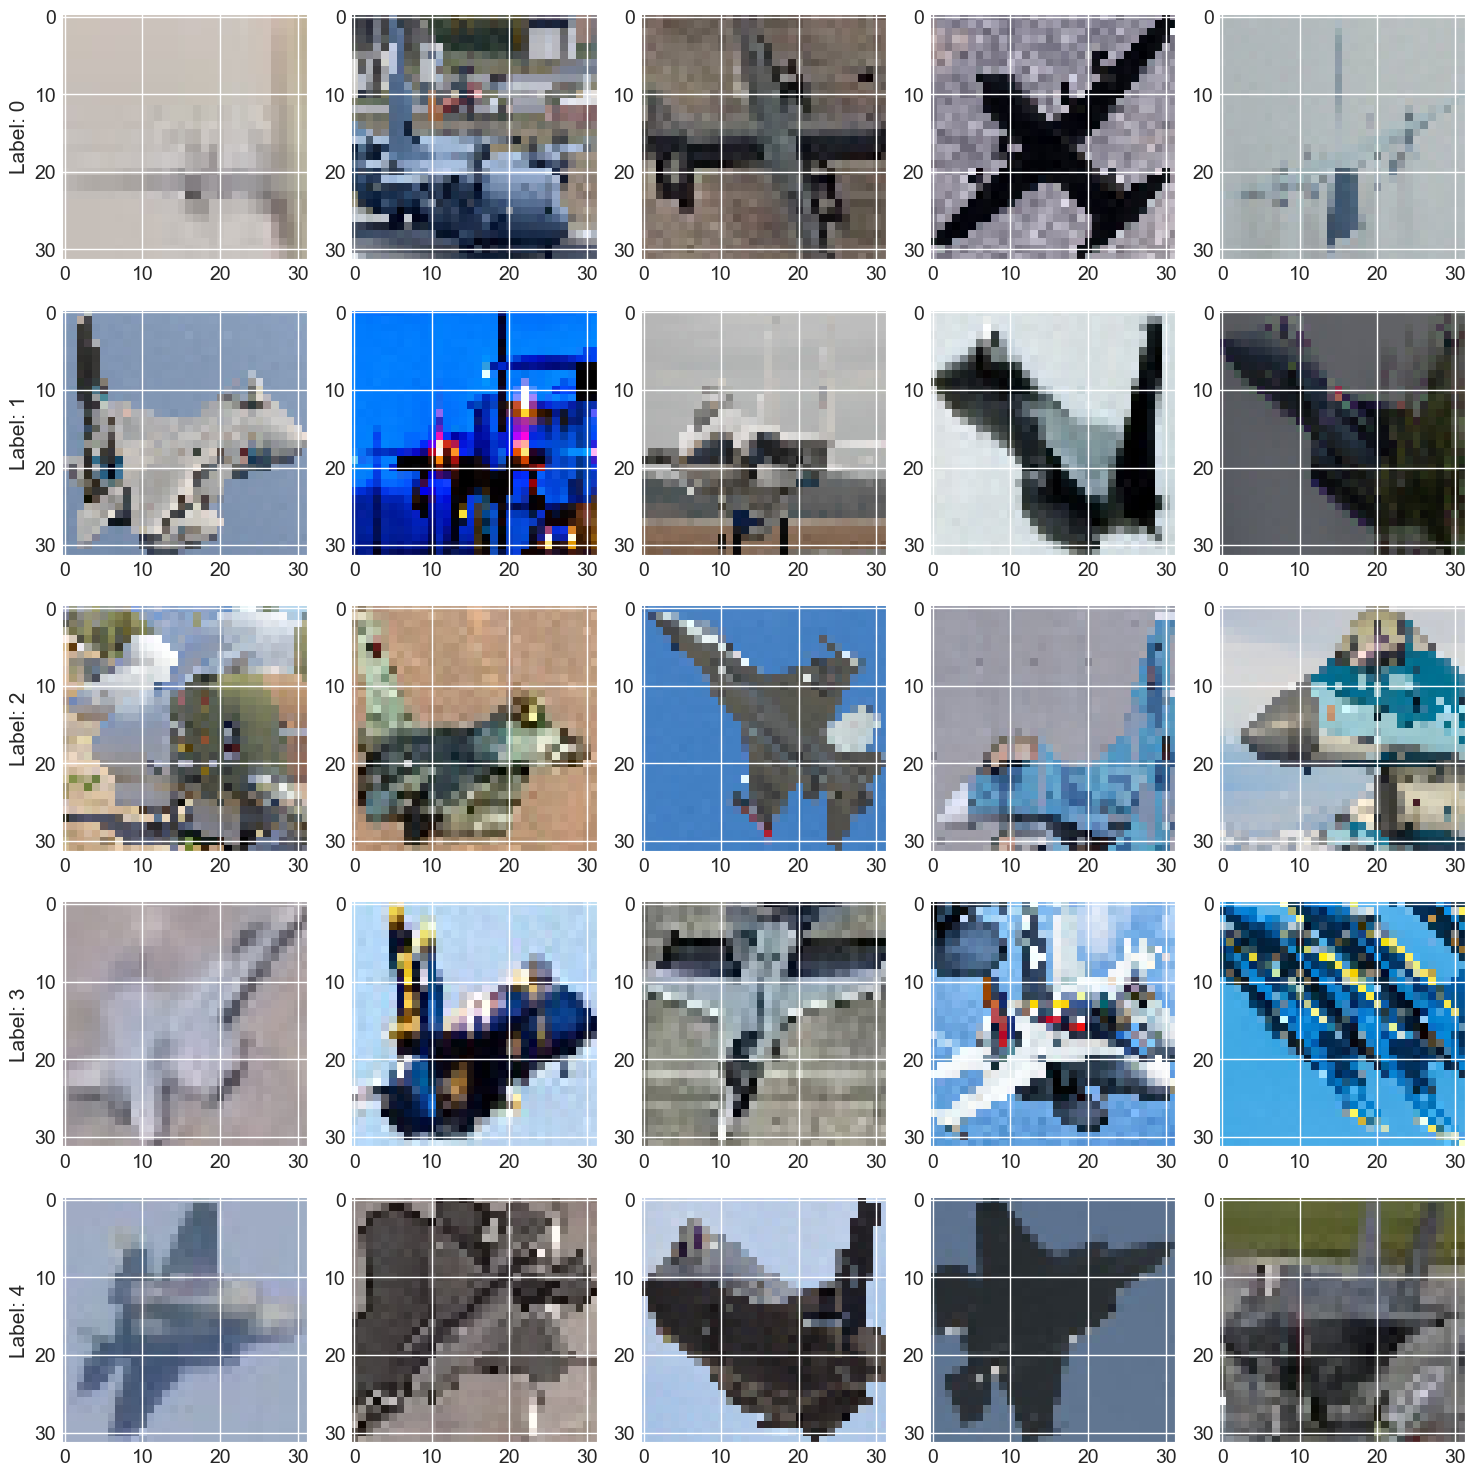

In [39]:
# Obtener etiquetas únicas desde el generador
unique_labels = range(len(train_generator.class_indices))  # Índices de las etiquetas únicas

# Mostrar imágenes por etiqueta
plot_images_by_label(train_generator, unique_labels)

# <center> **Modelos de DNN** </center>

**Modelo Base**

In [40]:
#Todas las metricas
all_metrics = {}

log_dir_model1_DNN = "logs/model1_DNN/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback_model1 = tf.keras.callbacks.TensorBoard(log_dir=log_dir_model1_DNN, histogram_freq=1)

In [41]:
model_base_DNN = tf.keras.models.Sequential([
              tf.keras.layers.Flatten(input_shape= (32, 32, 3)),
              tf.keras.layers.Dense(128, activation = "relu"),
              tf.keras.layers.Dense(256, activation = "relu"),
              tf.keras.layers.Dense(n_classes, activation = "softmax")
])


model_base_DNN.summary()

/Users/daniel/.pyenv/versions/3.10.13/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_6 (Flatten)             │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 128)            │       393,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 427,653 (1.63 MB)

 Trainable params: 427,653 (1.63 MB)

 Non-trainable params: 0 (0.00 B)

In [42]:
#Compilacion
model_base_DNN.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ['accuracy','precision','recall','auc'])

#Entrenamiento
history = model_base_DNN.fit(
    train_generator,
    epochs= 20,
    validation_data = test_generator,
    callbacks = [tensorboard_callback_model1]
)

#Guardar metrica
all_metrics["DNN_base"] = history.history

/Users/daniel/.pyenv/versions/3.10.13/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 26s 543ms/step - accuracy: 0.2101 - auc: 0.5174 - loss: 1.7544 - precision: 0.2133 - recall: 0.0289 - val_accuracy: 0.2005 - val_auc: 0.5425 - val_loss: 1.6291 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 24s 514ms/step - accuracy: 0.2603 - auc: 0.5889 - loss: 1.5787 - precision: 0.8341 - recall: 5.4737e-04 - val_accuracy: 0.2895 - val_auc: 0.6030 - val_loss: 1.5644 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 24s 519ms/step - accuracy: 0.2924 - auc: 0.6141 - loss: 1.5543 - precision: 0.8113 - recall: 0.0013 - val_accuracy: 0.2868 - val_auc: 0.6137 - val_loss: 1.5495 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 24s 516ms/step - accuracy: 0.3044 - auc: 0.6314 - loss: 1.5363 - precision: 0.6741 - recall: 0.0026 - val_accuracy: 0.3025 - val_auc: 0.6140 - val_loss: 1.5527 - val_precision: 0.6500 - val_recall: 0.0089


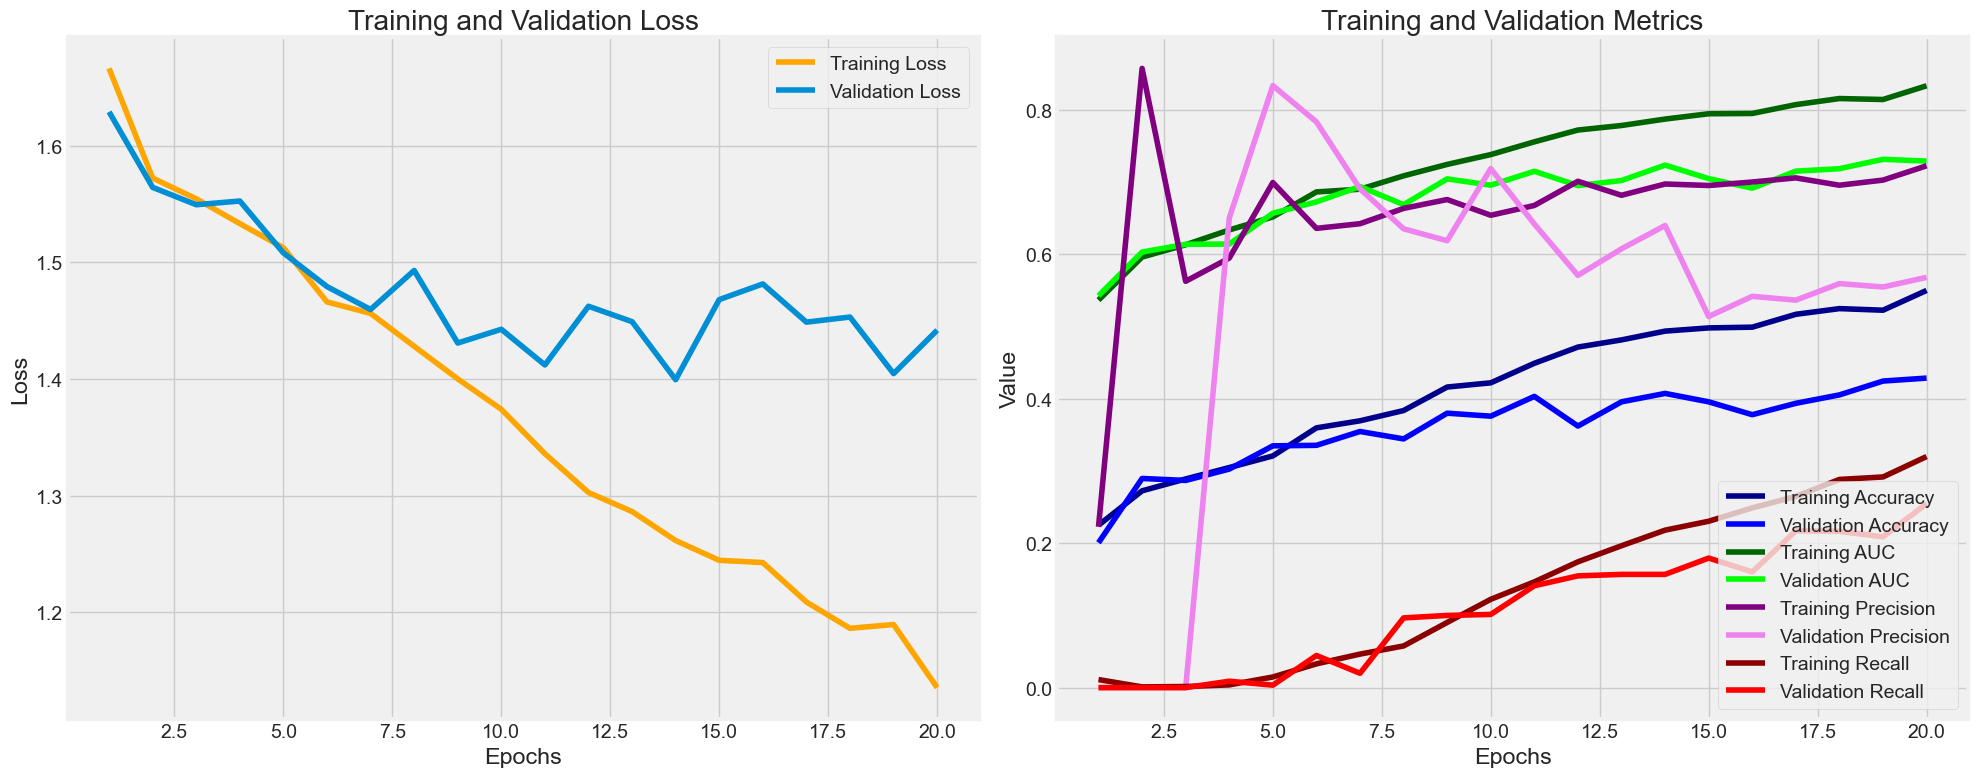

12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 407ms/step
Matriz de confusión guardada en: model1_DNN_confusion_matrix.png


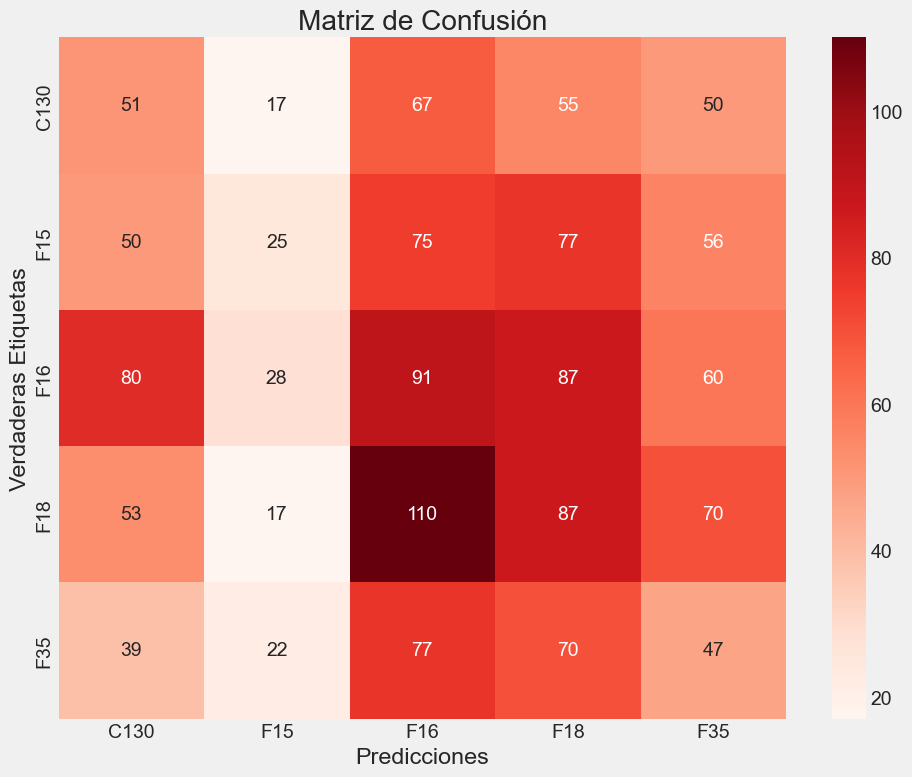

Reporte de Clasificación:
              precision    recall  f1-score   support

        C130       0.19      0.21      0.20       240
         F15       0.23      0.09      0.13       283
         F16       0.22      0.26      0.24       346
         F18       0.23      0.26      0.24       337
         F35       0.17      0.18      0.17       255

    accuracy                           0.21      1461
   macro avg       0.21      0.20      0.20      1461
weighted avg       0.21      0.21      0.20      1461

Reporte de clasificación guardado en: model1_DNN_classification_report.txt


In [43]:
plot_training_history(history, "model1_DNN")

# Suponiendo que tienes las etiquetas verdaderas y las predicciones del modelo
y_true = test_generator.classes  # Etiquetas verdaderas del conjunto de validación
y_pred = model_base_DNN.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convertir probabilidades a clases


# Nombres de las clases
class_names = list(test_generator.class_indices.keys())


# Llamada a la función
plot_confusion_matrix_and_classification_report(y_true, y_pred_classes, class_names, "model1_DNN")

In [44]:
model_base_DNN_V2 = tf.keras.models.Sequential([
              tf.keras.layers.Flatten(input_shape= (32, 32, 3)),
              tf.keras.layers.Dense(256, activation = "relu"),
              tf.keras.layers.Dense(128, activation = "relu"),
              tf.keras.layers.Dense(n_classes, activation = "softmax")
])


model_base_DNN_V2.summary()

/Users/daniel/.pyenv/versions/3.10.13/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_7 (Flatten)             │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 256)            │       786,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 820,229 (3.13 MB)

 Trainable params: 820,229 (3.13 MB)

 Non-trainable params: 0 (0.00 B)

In [45]:
#Compilacion
model_base_DNN_V2.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ['accuracy','precision','recall','auc'])

#Entrenamiento
history = model_base_DNN_V2.fit(
    train_generator,
    epochs= 20,
    validation_data = test_generator,
    callbacks = [tensorboard_callback_model1]
)

#Guardar metrica
all_metrics["DNN_base_Inversa"] = history.history

Epoch 1/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 25s 517ms/step - accuracy: 0.2193 - auc: 0.5123 - loss: 2.1180 - precision: 0.1954 - recall: 0.0501 - val_accuracy: 0.2594 - val_auc: 0.5916 - val_loss: 1.5796 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 26s 562ms/step - accuracy: 0.2686 - auc: 0.5817 - loss: 1.5838 - precision: 0.4043 - recall: 2.7290e-04 - val_accuracy: 0.2916 - val_auc: 0.6144 - val_loss: 1.5537 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 24s 524ms/step - accuracy: 0.2984 - auc: 0.6176 - loss: 1.5529 - precision: 0.5015 - recall: 0.0030 - val_accuracy: 0.3217 - val_auc: 0.6547 - val_loss: 1.5209 - val_precision: 0.6000 - val_recall: 0.0021
Epoch 4/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 23s 511ms/step - accuracy: 0.3190 - auc: 0.6449 - loss: 1.5261 - precision: 0.5819 - recall: 0.0069 - val_accuracy: 0.3306 - val_auc: 0.6481 - val_loss: 1.5215 - val_precision: 1.0000 - val_recall: 0.0014
Epoch 5/

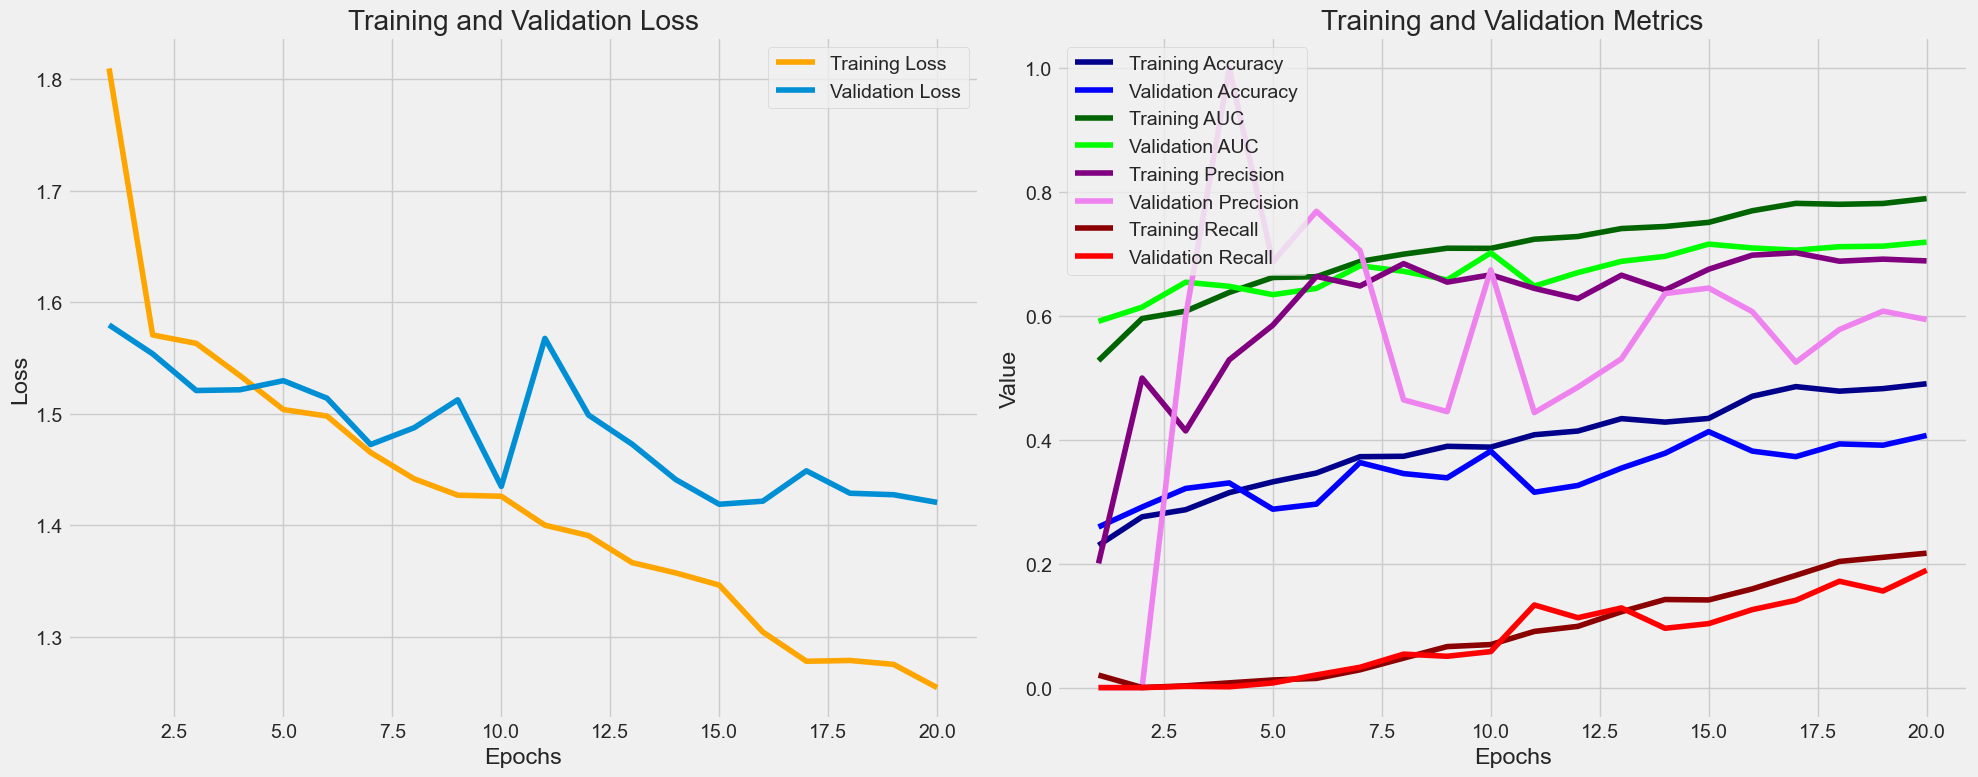

12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 388ms/step
Matriz de confusión guardada en: model1_DNN_inversa_confusion_matrix.png


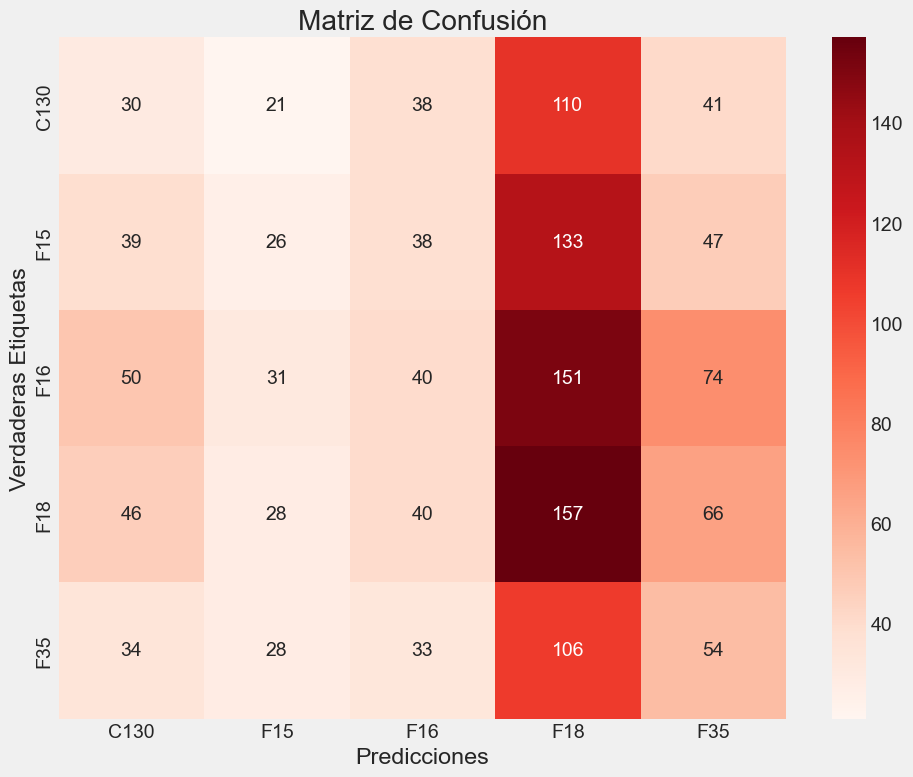

Reporte de Clasificación:
              precision    recall  f1-score   support

        C130       0.15      0.12      0.14       240
         F15       0.19      0.09      0.12       283
         F16       0.21      0.12      0.15       346
         F18       0.24      0.47      0.32       337
         F35       0.19      0.21      0.20       255

    accuracy                           0.21      1461
   macro avg       0.20      0.20      0.19      1461
weighted avg       0.20      0.21      0.19      1461

Reporte de clasificación guardado en: model1_DNN_inversa_classification_report.txt


In [46]:
plot_training_history(history, "model1_DNN_inversa")

# Suponiendo que tienes las etiquetas verdaderas y las predicciones del modelo
y_true = test_generator.classes  # Etiquetas verdaderas del conjunto de validación
y_pred = model_base_DNN_V2.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convertir probabilidades a clases


# Nombres de las clases
class_names = list(test_generator.class_indices.keys())


# Llamada a la función
plot_confusion_matrix_and_classification_report(y_true, y_pred_classes, class_names, "model1_DNN_inversa")




In [47]:
model_base_DNN_V3 = tf.keras.models.Sequential([
              tf.keras.layers.Flatten(input_shape= (32, 32, 3)),
              tf.keras.layers.Dense(128, activation = "relu"),
              tf.keras.layers.Dense(256, activation = "relu"),
              tf.keras.layers.Dense(512, activation = "relu"),
              tf.keras.layers.Dense(n_classes, activation = "softmax")
])


model_base_DNN_V3.summary()

/Users/daniel/.pyenv/versions/3.10.13/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_8 (Flatten)             │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 128)            │       393,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 560,517 (2.14 MB)

 Trainable params: 560,517 (2.14 MB)

 Non-trainable params: 0 (0.00 B)

In [48]:
#Compilacion
model_base_DNN_V3.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ['accuracy','precision','recall','auc'])

#Entrenamiento
history = model_base_DNN_V3.fit(
    train_generator,
    epochs= 20,
    validation_data = test_generator,
    callbacks = [tensorboard_callback_model1]
)

#Guardar metrica
all_metrics["DNN_base_+Neuronas"] = history.history

Epoch 1/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 26s 542ms/step - accuracy: 0.2193 - auc: 0.5227 - loss: 1.6478 - precision: 0.2077 - recall: 0.0016 - val_accuracy: 0.2724 - val_auc: 0.6040 - val_loss: 1.5678 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 23s 505ms/step - accuracy: 0.2705 - auc: 0.5910 - loss: 1.5716 - precision: 0.1752 - recall: 4.1350e-04 - val_accuracy: 0.2957 - val_auc: 0.6145 - val_loss: 1.5529 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 25s 548ms/step - accuracy: 0.2950 - auc: 0.6135 - loss: 1.5506 - precision: 0.4066 - recall: 0.0033 - val_accuracy: 0.2882 - val_auc: 0.6222 - val_loss: 1.5378 - val_precision: 1.0000 - val_recall: 6.8446e-04
Epoch 4/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 23s 501ms/step - accuracy: 0.3296 - auc: 0.6599 - loss: 1.5025 - precision: 0.6413 - recall: 0.0144 - val_accuracy: 0.3285 - val_auc: 0.6582 - val_loss: 1.4993 - val_precision: 0.5882 - val_recall: 0.0274
Epoc

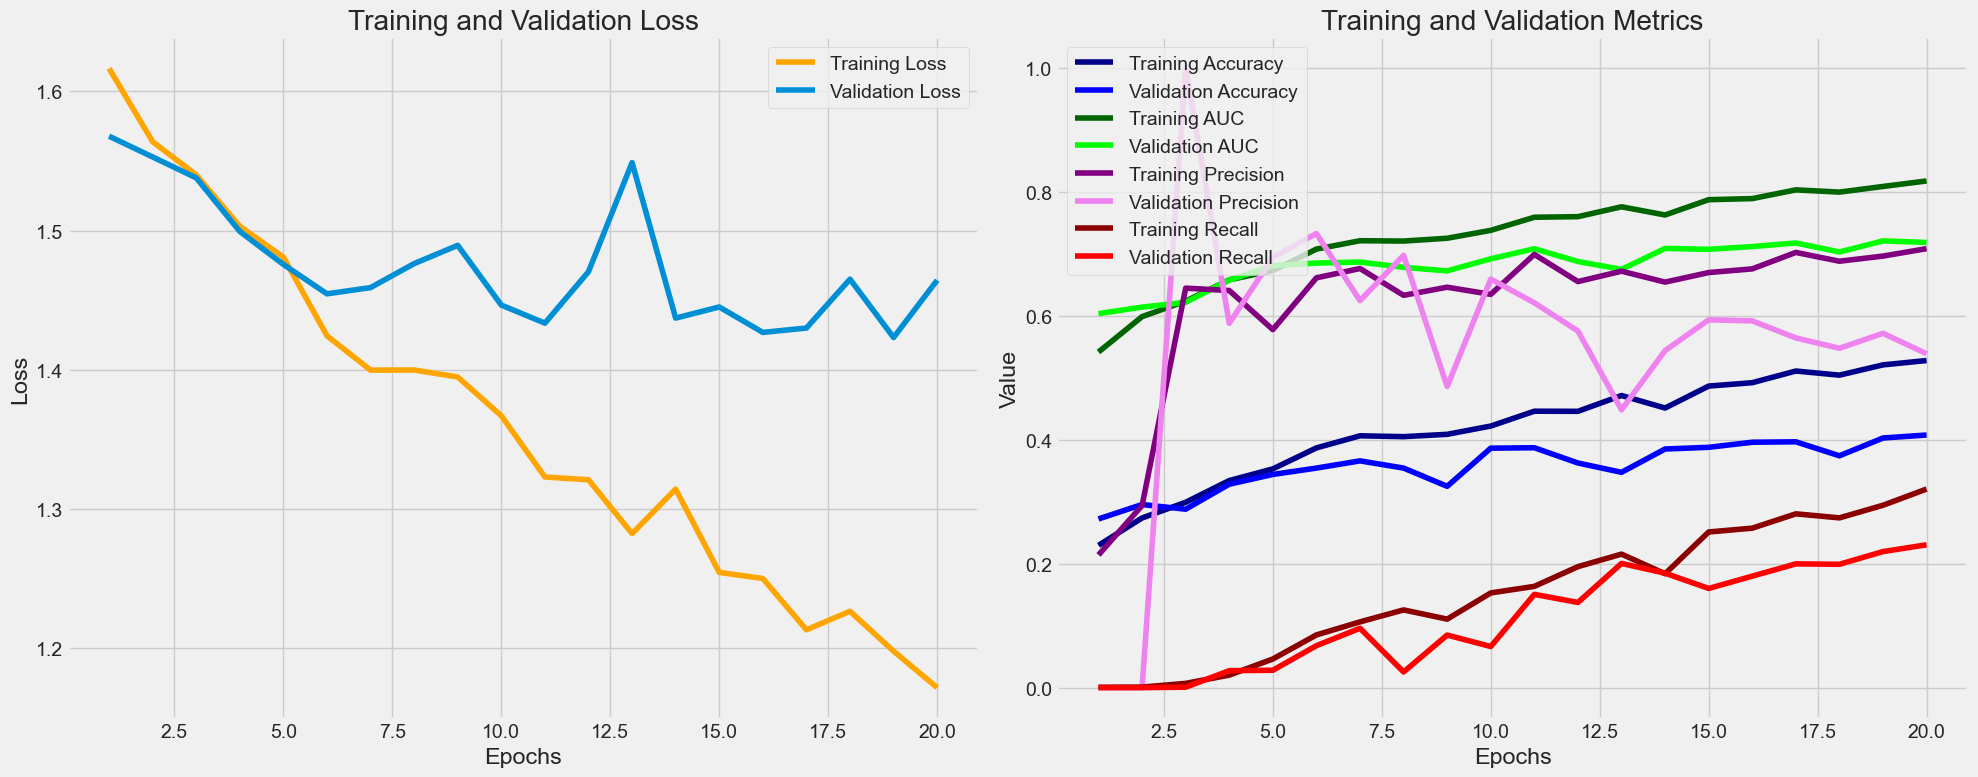

12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 389ms/step
Matriz de confusión guardada en: model1_DNN_+neuronas_confusion_matrix.png


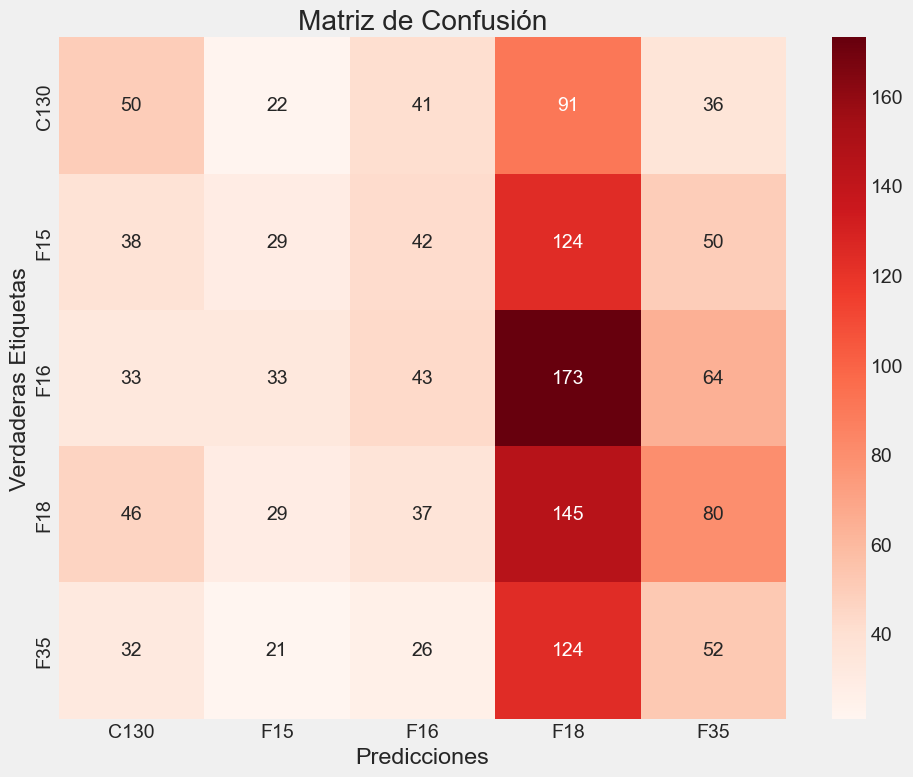

Reporte de Clasificación:
              precision    recall  f1-score   support

        C130       0.25      0.21      0.23       240
         F15       0.22      0.10      0.14       283
         F16       0.23      0.12      0.16       346
         F18       0.22      0.43      0.29       337
         F35       0.18      0.20      0.19       255

    accuracy                           0.22      1461
   macro avg       0.22      0.21      0.20      1461
weighted avg       0.22      0.22      0.20      1461

Reporte de clasificación guardado en: model1_DNN_+neuronas_classification_report.txt


In [49]:
plot_training_history(history, "model1_DNN_+neuronas")

# Suponiendo que tienes las etiquetas verdaderas y las predicciones del modelo
y_true = test_generator.classes  # Etiquetas verdaderas del conjunto de validación
y_pred = model_base_DNN_V2.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convertir probabilidades a clases


# Nombres de las clases
class_names = list(test_generator.class_indices.keys())


# Llamada a la función
plot_confusion_matrix_and_classification_report(y_true, y_pred_classes, class_names, "model1_DNN_+neuronas")


In [50]:
model_base_DNN_V4 = tf.keras.models.Sequential([
              tf.keras.layers.Flatten(input_shape= (32, 32, 3)),
              tf.keras.layers.Dense(32, activation = "relu"),
              tf.keras.layers.Dense(72, activation = "relu"),
              tf.keras.layers.Dense(128, activation = "relu"),
              tf.keras.layers.Dense(512, activation = "relu"),
              tf.keras.layers.Dense(n_classes, activation = "softmax")
])


model_base_DNN_V4.summary()

/Users/daniel/.pyenv/versions/3.10.13/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_9 (Flatten)             │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 32)             │        98,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 72)             │         2,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 128)            │         9,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 178,669 (697.93 KB)

 Trainable params: 178,669 (697.93 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 24s 534ms/step - accuracy: 0.5367 - auc: 0.8244 - loss: 1.1548 - precision: 0.7151 - recall: 0.3457 - val_accuracy: 0.4189 - val_auc: 0.7270 - val_loss: 1.4378 - val_precision: 0.5562 - val_recall: 0.2608
Epoch 2/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 23s 492ms/step - accuracy: 0.5607 - auc: 0.8407 - loss: 1.1056 - precision: 0.7328 - recall: 0.3670 - val_accuracy: 0.4271 - val_auc: 0.7366 - val_loss: 1.4162 - val_precision: 0.5789 - val_recall: 0.2663
Epoch 3/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 23s 492ms/step - accuracy: 0.5390 - auc: 0.8328 - loss: 1.1309 - precision: 0.7136 - recall: 0.3633 - val_accuracy: 0.4052 - val_auc: 0.7244 - val_loss: 1.4673 - val_precision: 0.5297 - val_recall: 0.2621
Epoch 4/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 22s 481ms/step - accuracy: 0.5827 - auc: 0.8496 - loss: 1.0755 - precision: 0.7549 - recall: 0.3909 - val_accuracy: 0.4237 - val_auc: 0.7302 - val_loss: 1.4463 - val_precision: 0.5572 - val_recall: 0.2601
Epoch 5/20
46/46 ━━━━━━━━━━━

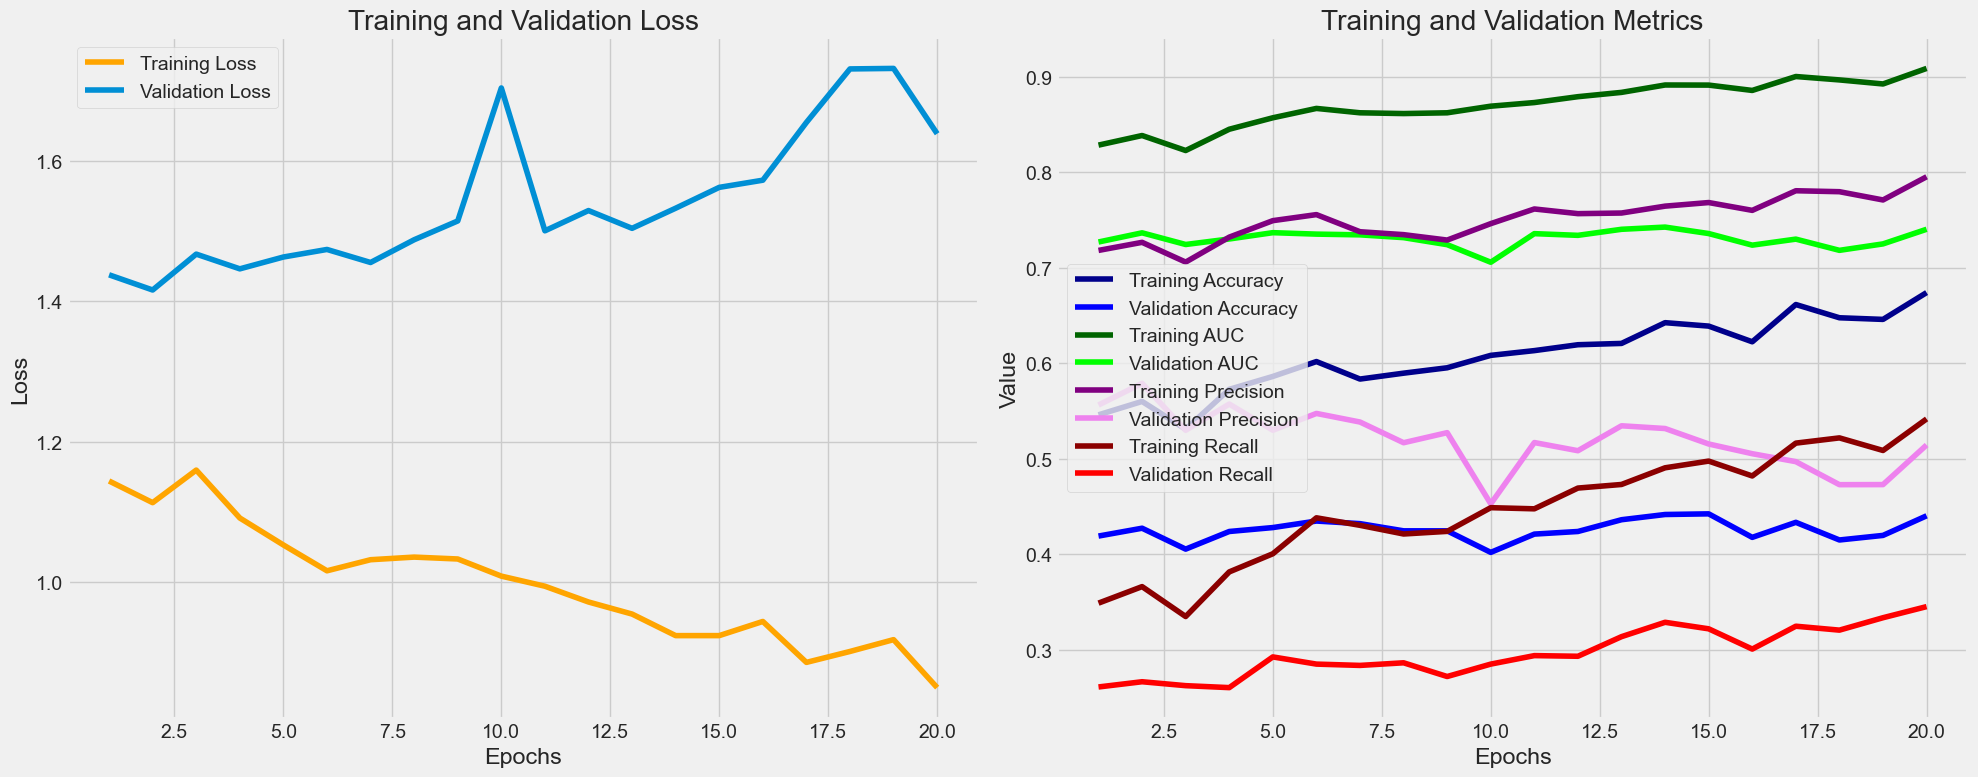

12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 375ms/step
Matriz de confusión guardada en: model1_DNN_+Capas_confusion_matrix.png


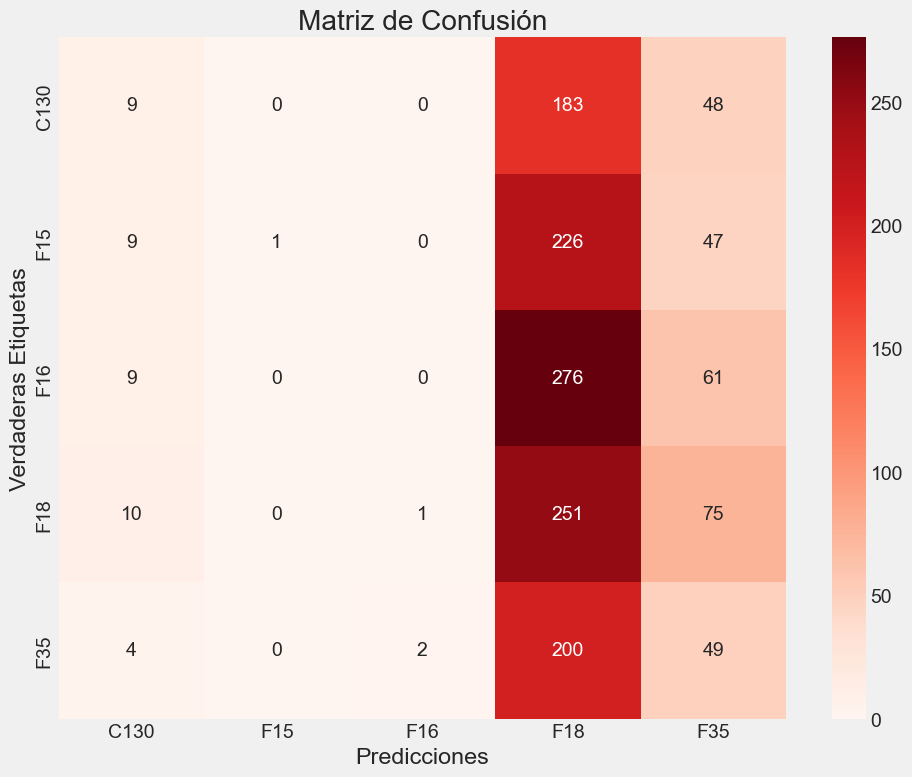

Reporte de Clasificación:
              precision    recall  f1-score   support

        C130       0.22      0.04      0.06       240
         F15       1.00      0.00      0.01       283
         F16       0.00      0.00      0.00       346
         F18       0.22      0.74      0.34       337
         F35       0.17      0.19      0.18       255

    accuracy                           0.21      1461
   macro avg       0.32      0.20      0.12      1461
weighted avg       0.31      0.21      0.12      1461

Reporte de clasificación guardado en: model1_DNN_+Capas_classification_report.txt


In [51]:
#Compilacion
model_base_DNN_V4.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ['accuracy','precision','recall','auc'])

#Entrenamiento
history = model_base_DNN_V3.fit(
    train_generator,
    epochs= 20,
    validation_data = test_generator,
    callbacks = [tensorboard_callback_model1]
)

#Guardar metrica
all_metrics["DNN_base_+Capas"] = history.history

plot_training_history(history, "model1_DNN_+Capas")

# Suponiendo que tienes las etiquetas verdaderas y las predicciones del modelo
y_true = test_generator.classes  # Etiquetas verdaderas del conjunto de validación
y_pred = model_base_DNN_V4.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convertir probabilidades a clases

# Nombres de las clases
class_names = list(test_generator.class_indices.keys())

# Llamada a la función
plot_confusion_matrix_and_classification_report(y_true, y_pred_classes, class_names, "model1_DNN_+Capas")


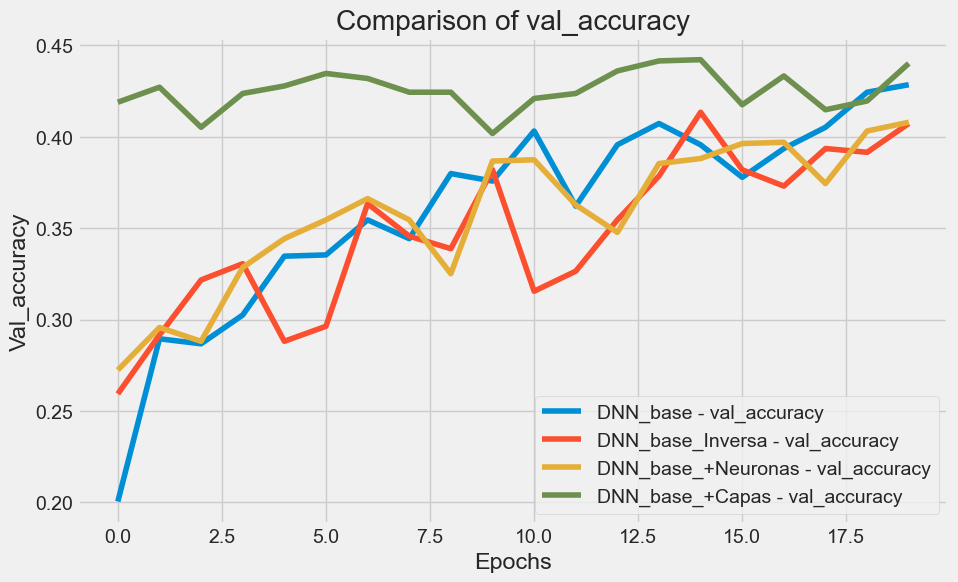

In [52]:
plot_model_metrics(all_metrics, "val_accuracy")

all_metrics = {}

# <center> **Modelos de CNN** </center>


In [53]:
model_base_CNN = tf.keras.models.Sequential([
    Conv2D(75, (3,3), activation = "relu", input_shape= (32, 32, 3)),
    Flatten(),
    Dense(n_classes ,activation="softmax")
])

model_base_CNN.summary()

/Users/daniel/.pyenv/versions/3.10.13/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 30, 30, 75)     │         2,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 67500)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 5)              │       337,505 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 339,605 (1.30 MB)

 Trainable params: 339,605 (1.30 MB)

 Non-trainable params: 0 (0.00 B)

In [54]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [55]:
# Compilación del modelo
model_base_CNN.compile(optimizer="adam",
                       loss="categorical_crossentropy",
                       metrics=['accuracy','precision','recall','auc'])

# Entrenamiento del modelo
history = model_base_CNN.fit(
    train_generator,  
    epochs=30,       
    validation_data=test_generator
)

Epoch 1/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 23s 498ms/step - accuracy: 0.2630 - auc: 0.5376 - loss: 2.0763 - precision: 0.2374 - recall: 0.0459 - val_accuracy: 0.3621 - val_auc: 0.6574 - val_loss: 1.5275 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 22s 479ms/step - accuracy: 0.4420 - auc: 0.7339 - loss: 1.4304 - precision: 0.8723 - recall: 0.0272 - val_accuracy: 0.4045 - val_auc: 0.7303 - val_loss: 1.3847 - val_precision: 0.7841 - val_recall: 0.0945
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 22s 480ms/step - accuracy: 0.5572 - auc: 0.8325 - loss: 1.1901 - precision: 0.8953 - recall: 0.1967 - val_accuracy: 0.4565 - val_auc: 0.7565 - val_loss: 1.3398 - val_precision: 0.6227 - val_recall: 0.1841
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 22s 483ms/step - accuracy: 0.6313 - auc: 0.8787 - loss: 1.0337 - precision: 0.8726 - recall: 0.3352 - val_accuracy: 0.4825 - val_auc: 0.7691 - val_loss: 1.3187 - val_precision: 0.6415 - val_recall: 0.2560
Epoch 5/30
46/46 ━━━

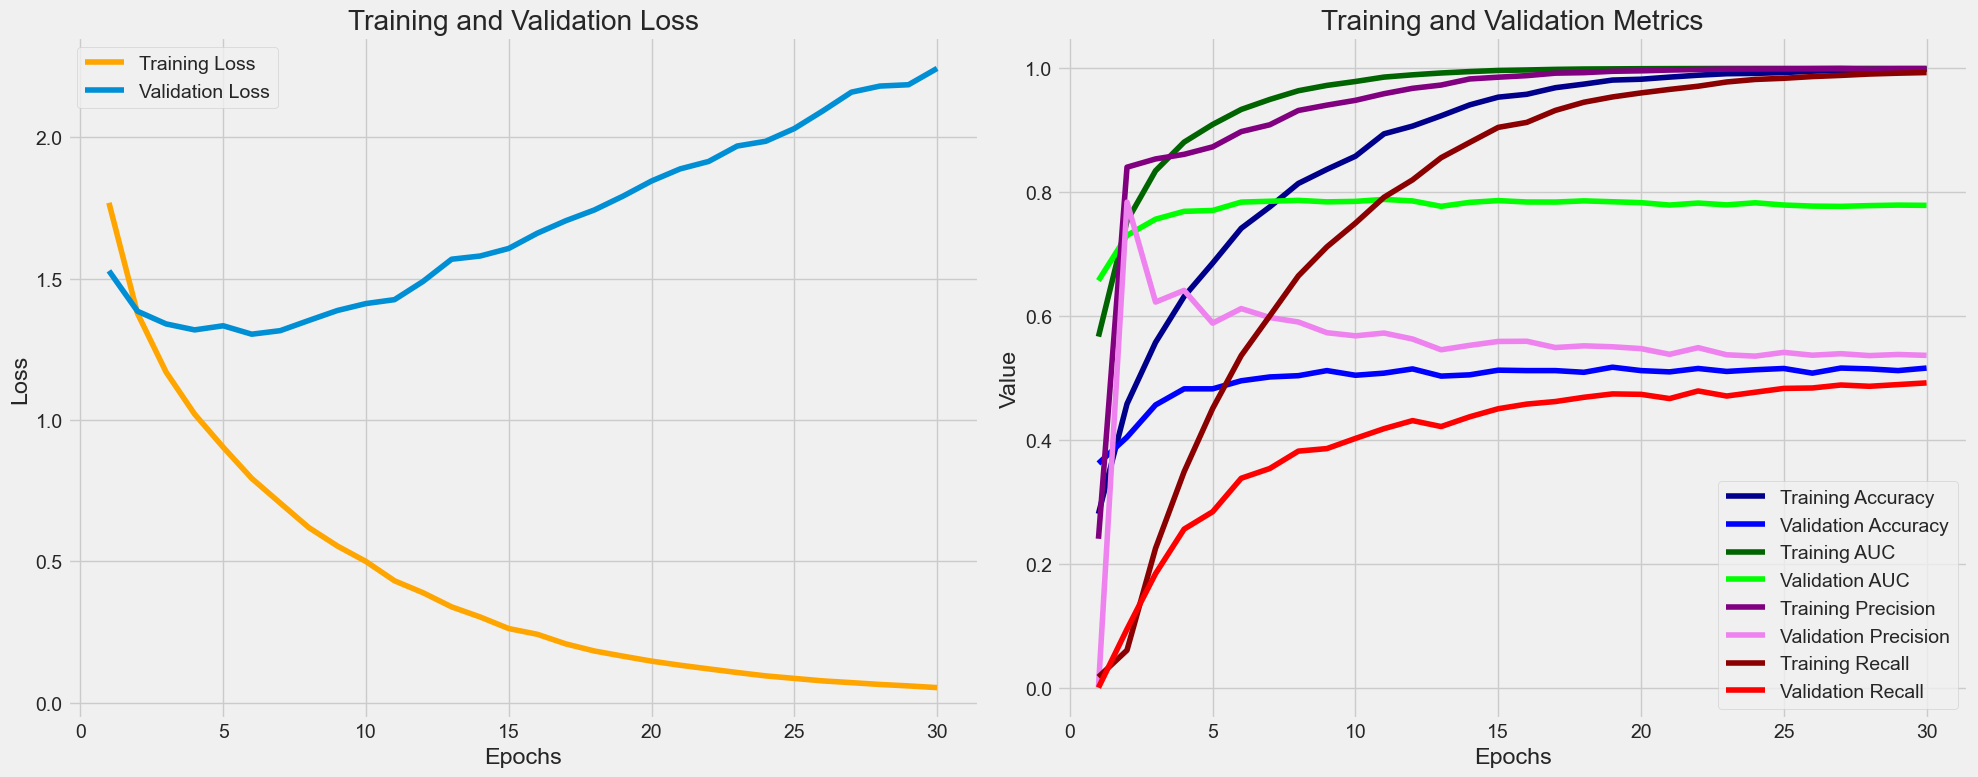

12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 395ms/step
Matriz de confusión guardada en: model_CNN_base_confusion_matrix.png


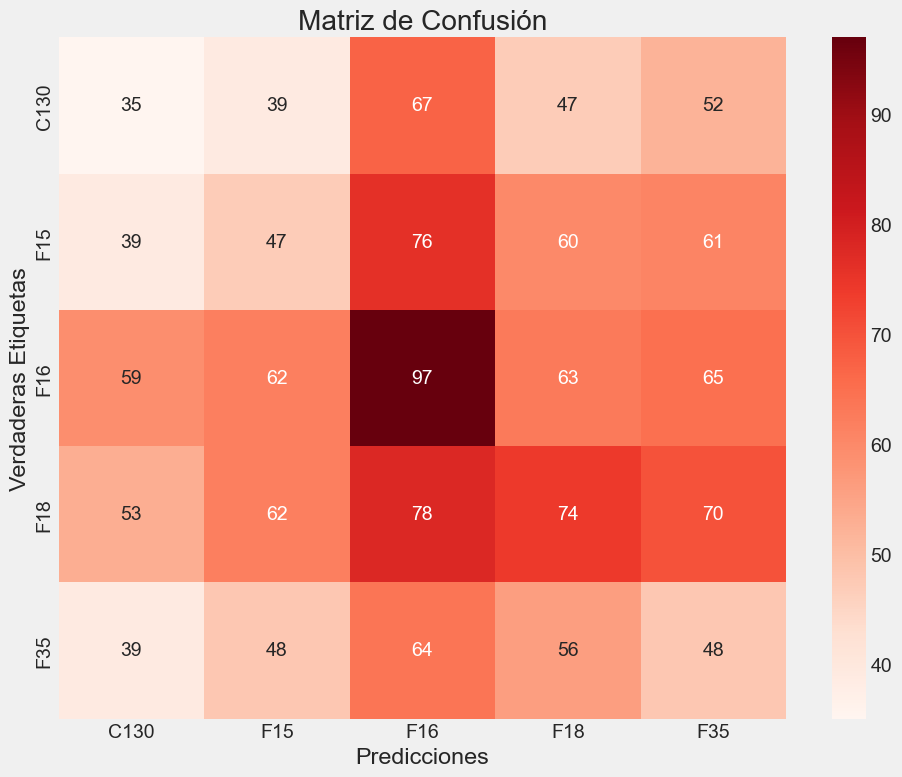

Reporte de Clasificación:
              precision    recall  f1-score   support

        C130       0.16      0.15      0.15       240
         F15       0.18      0.17      0.17       283
         F16       0.25      0.28      0.27       346
         F18       0.25      0.22      0.23       337
         F35       0.16      0.19      0.17       255

    accuracy                           0.21      1461
   macro avg       0.20      0.20      0.20      1461
weighted avg       0.21      0.21      0.21      1461

Reporte de clasificación guardado en: model_CNN_base_classification_report.txt


In [56]:
#Guardar metrica
all_metrics["model_CNN_base"] = history.history

plot_training_history(history, "model_CNN_base")

# Suponiendo que tienes las etiquetas verdaderas y las predicciones del modelo
y_true = test_generator.classes  # Etiquetas verdaderas del conjunto de validación
y_pred = model_base_CNN.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convertir probabilidades a clases

# Nombres de las clases
class_names = list(test_generator.class_indices.keys())

# Llamada a la función
plot_confusion_matrix_and_classification_report(y_true, y_pred_classes, class_names, "model_CNN_base")

In [57]:
model_base_CNN_CONV = tf.keras.models.Sequential([
    Conv2D(75, (3,3), activation = "relu", input_shape= (32, 32, 3)),
    Flatten(),
    Dense(256, activation = "relu"),
    Dense(128, activation = "relu"),
    Dense(n_classes ,activation="softmax")
])

model_base_CNN_CONV.summary()

/Users/daniel/.pyenv/versions/3.10.13/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 30, 30, 75)     │         2,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 67500)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 256)            │    17,280,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,315,897 (66.05 MB)

 Trainable params: 17,315,897 (66.05 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 24s 512ms/step - accuracy: 0.2061 - auc: 0.5051 - loss: 2.7466 - precision: 0.1932 - recall: 0.0671 - val_accuracy: 0.3101 - val_auc: 0.6430 - val_loss: 1.5422 - val_precision: 0.6667 - val_recall: 0.0055
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 23s 495ms/step - accuracy: 0.3764 - auc: 0.6912 - loss: 1.4801 - precision: 0.7739 - recall: 0.0150 - val_accuracy: 0.3867 - val_auc: 0.7064 - val_loss: 1.4266 - val_precision: 0.6739 - val_recall: 0.1061
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 24s 515ms/step - accuracy: 0.5085 - auc: 0.8025 - loss: 1.2467 - precision: 0.8286 - recall: 0.1698 - val_accuracy: 0.4634 - val_auc: 0.7578 - val_loss: 1.3358 - val_precision: 0.6392 - val_recall: 0.2122
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 24s 518ms/step - accuracy: 0.6358 - auc: 0.8828 - loss: 0.9983 - precision: 0.8397 - recall: 0.3923 - val_accuracy: 0.4716 - val_auc: 0.7635 - val_loss: 1.3793 - val_precision: 0.5599 - val_recall: 0.3039
Epoch 5/30
46/46 ━━━━━━━━━━━

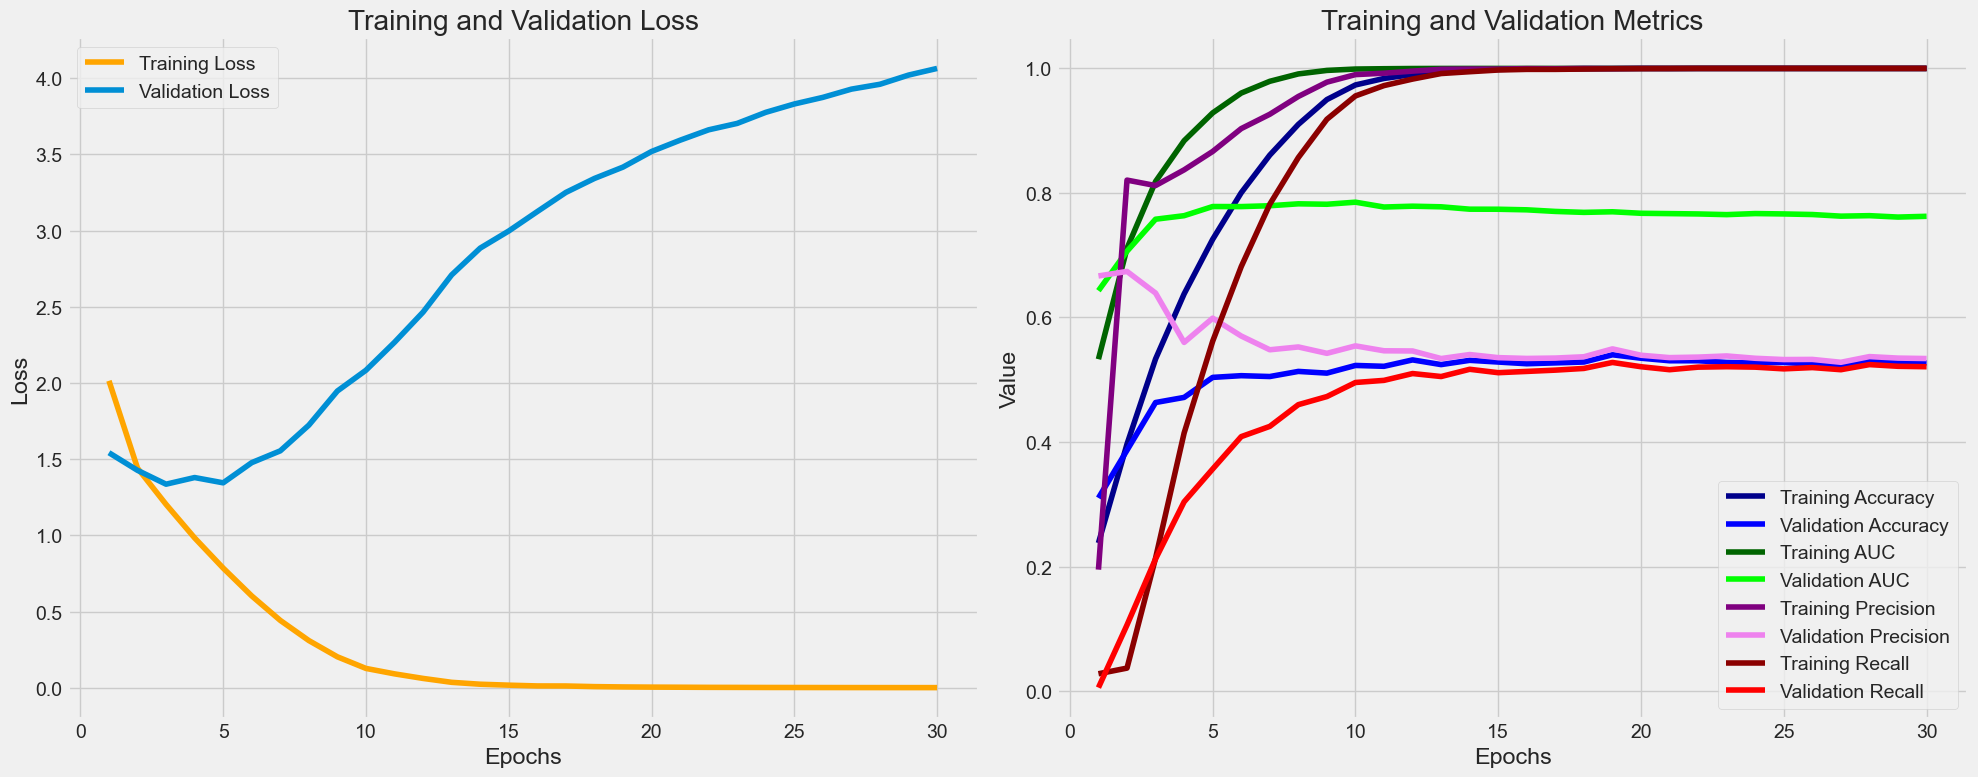

12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 373ms/step
Matriz de confusión guardada en: model_base_CNN_CONV_matrix_confusion_matrix.png


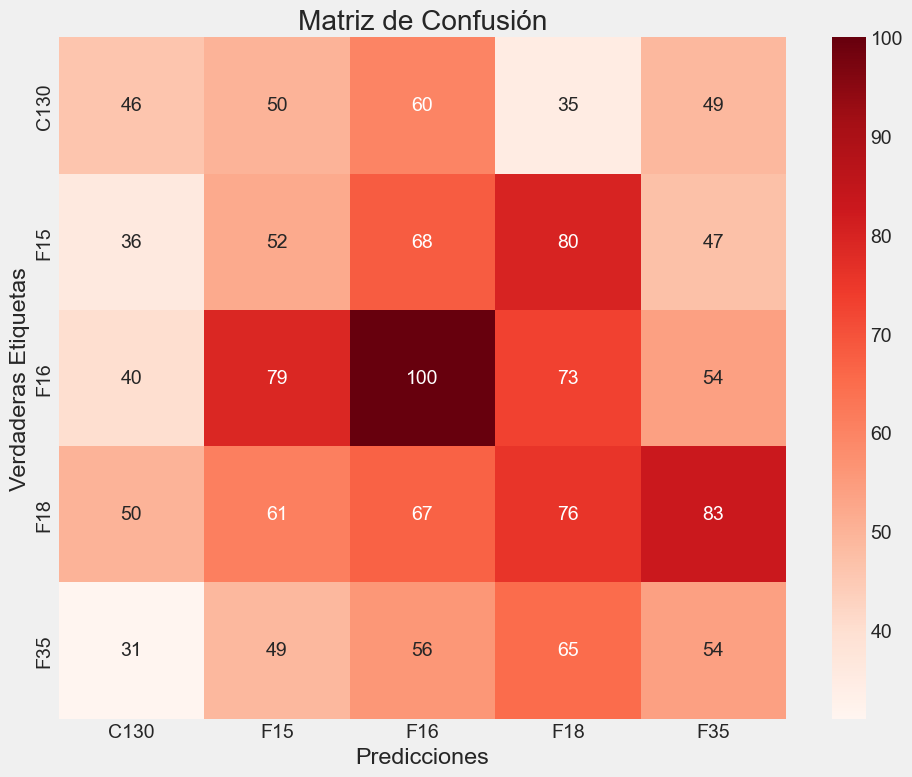

Reporte de Clasificación:
              precision    recall  f1-score   support

        C130       0.23      0.19      0.21       240
         F15       0.18      0.18      0.18       283
         F16       0.28      0.29      0.29       346
         F18       0.23      0.23      0.23       337
         F35       0.19      0.21      0.20       255

    accuracy                           0.22      1461
   macro avg       0.22      0.22      0.22      1461
weighted avg       0.23      0.22      0.22      1461

Reporte de clasificación guardado en: model_base_CNN_CONV_matrix_classification_report.txt


In [58]:
# Compilación del modelo
model_base_CNN_CONV.compile(optimizer="adam",
                       loss="categorical_crossentropy",
                       metrics=['accuracy','precision','recall','auc'])

# Entrenamiento del modelo
history = model_base_CNN_CONV.fit(
    train_generator,
    epochs=30,
    validation_data=test_generator
)

#Guardar metrica
all_metrics["model_base_CNN_CONV"] = history.history

plot_training_history(history, "model_base_CNN_CONV_training")

# Suponiendo que tienes las etiquetas verdaderas y las predicciones del modelo
y_true = test_generator.classes  # Etiquetas verdaderas del conjunto de validación
y_pred = model_base_CNN_CONV.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convertir probabilidades a clases

# Nombres de las clases
class_names = list(test_generator.class_indices.keys())

# Llamada a la función
plot_confusion_matrix_and_classification_report(y_true, y_pred_classes, class_names, "model_base_CNN_CONV_matrix")

In [59]:
model_base_CNN_DROPOUT = tf.keras.models.Sequential([
    Conv2D(75, (3,3), activation = "relu", input_shape= (32, 32, 3)),
    Flatten(),
    Dense(256, activation = "relu"),
    Dropout(0.5),
    Dense(128, activation = "relu"),
    Dropout(0.5),
    Dense(n_classes ,activation="softmax")
])

model_base_CNN_DROPOUT.summary()

/Users/daniel/.pyenv/versions/3.10.13/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 30, 30, 75)     │         2,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_12 (Flatten)            │ (None, 67500)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 256)            │    17,280,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,315,897 (66.05 MB)

 Trainable params: 17,315,897 (66.05 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 24s 495ms/step - accuracy: 0.2139 - auc: 0.5122 - loss: 2.0800 - precision: 0.1986 - recall: 0.0486 - val_accuracy: 0.2416 - val_auc: 0.5827 - val_loss: 1.5945 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 22s 483ms/step - accuracy: 0.2199 - auc: 0.5509 - loss: 1.5975 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.2553 - val_auc: 0.6137 - val_loss: 1.5741 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 22s 484ms/step - accuracy: 0.2530 - auc: 0.5887 - loss: 1.5711 - precision: 0.5196 - recall: 0.0024 - val_accuracy: 0.3340 - val_auc: 0.6648 - val_loss: 1.5360 - val_precision: 1.0000 - val_recall: 0.0034
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 22s 482ms/step - accuracy: 0.3114 - auc: 0.6538 - loss: 1.5073 - precision: 0.6661 - recall: 0.0183 - val_accuracy: 0.3956 - val_auc: 0.7163 - val_loss: 1.4580 - val_precision: 1.0000 - val_recall: 0.0082
Epoc

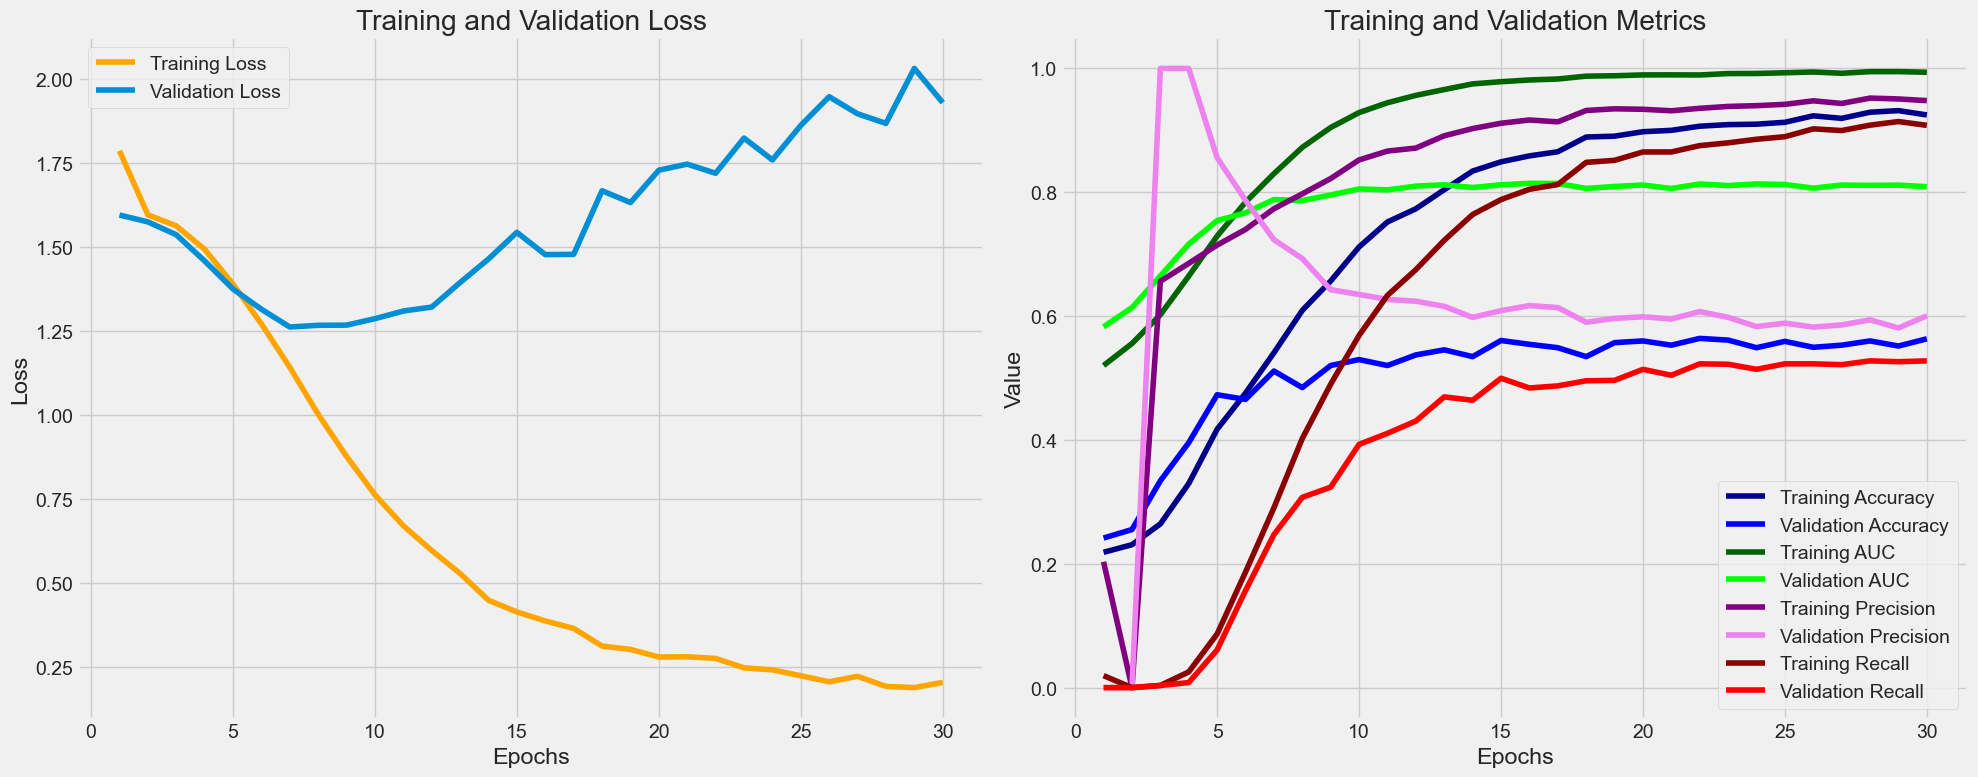

12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 375ms/step
Matriz de confusión guardada en: model_base_CNN_DROPOUT_confusion_matrix.png


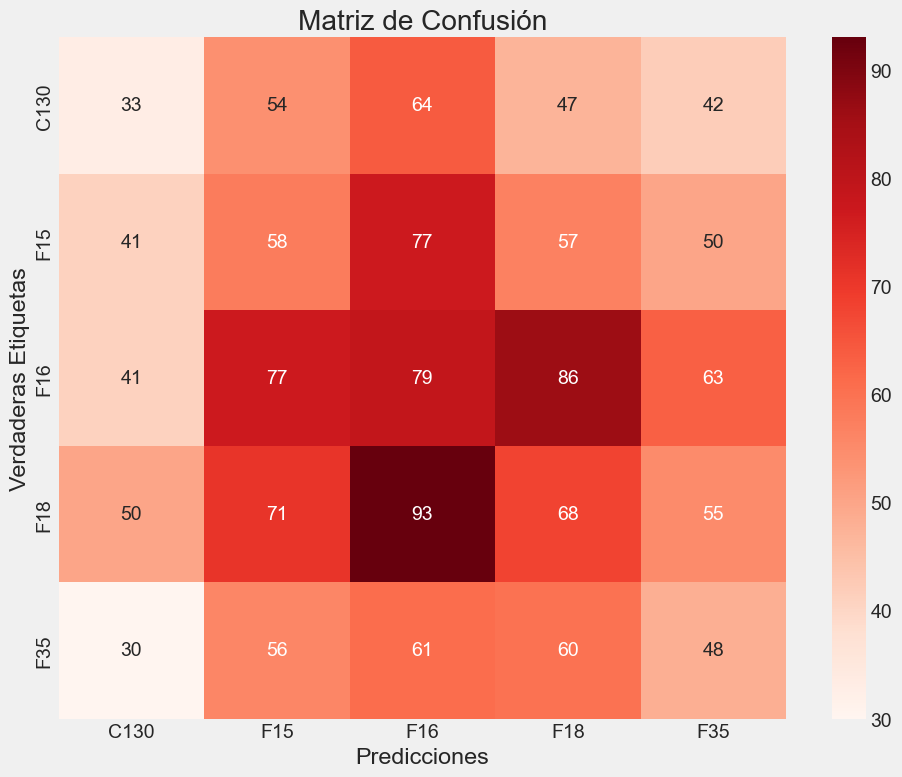

Reporte de Clasificación:
              precision    recall  f1-score   support

        C130       0.17      0.14      0.15       240
         F15       0.18      0.20      0.19       283
         F16       0.21      0.23      0.22       346
         F18       0.21      0.20      0.21       337
         F35       0.19      0.19      0.19       255

    accuracy                           0.20      1461
   macro avg       0.19      0.19      0.19      1461
weighted avg       0.20      0.20      0.19      1461

Reporte de clasificación guardado en: model_base_CNN_DROPOUT_classification_report.txt


In [60]:
model_base_CNN_DROPOUT.compile(optimizer="adam",
                       loss="categorical_crossentropy",
                       metrics=['accuracy','precision','recall','auc'])

# Entrenamiento del modelo
history = model_base_CNN_DROPOUT.fit(
    train_generator,
    epochs=30,
    validation_data=test_generator
)

#Guardar metrica
all_metrics["model_base_CNN_DROPOUT"] = history.history

plot_training_history(history, "model_base_CNN_DROPOUT")

# Suponiendo que tienes las etiquetas verdaderas y las predicciones del modelo
y_true = test_generator.classes  # Etiquetas verdaderas del conjunto de validación
y_pred = model_base_CNN_DROPOUT.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convertir probabilidades a clases

# Nombres de las clases
class_names = list(test_generator.class_indices.keys())

# Llamada a la función
plot_confusion_matrix_and_classification_report(y_true, y_pred_classes, class_names, "model_base_CNN_DROPOUT")

In [61]:
model_base_CNN_TODO = tf.keras.models.Sequential([
    Conv2D(32, (2,2), activation = "relu", input_shape= (32, 32, 3)),
    Dropout(0.2),
    Conv2D(64, (2,2), activation = "relu", input_shape= (32, 32, 3)),
    Dropout(0.2),
    Conv2D(128, (2,2), activation = "relu", input_shape= (32, 32, 3)),
    Flatten(),
    Dense(256, activation = "relu"),
    Dropout(0.2),
    Dense(128, activation = "relu"),
    Dropout(0.2),
    Dense(n_classes ,activation="softmax")
])

model_base_CNN_TODO.summary()

/Users/daniel/.pyenv/versions/3.10.13/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 31, 31, 32)     │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 30, 30, 64)     │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 29, 29, 128)    │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ (None, 107648)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 256)            │    27,558,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,633,253 (105.41 MB)

 Trainable params: 27,633,253 (105.41 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 25s 522ms/step - accuracy: 0.2143 - auc: 0.5180 - loss: 3.5257 - precision: 0.2207 - recall: 0.0797 - val_accuracy: 0.2368 - val_auc: 0.5678 - val_loss: 1.6043 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 25s 534ms/step - accuracy: 0.2389 - auc: 0.5517 - loss: 1.5998 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.2697 - val_auc: 0.5980 - val_loss: 1.5868 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 23s 502ms/step - accuracy: 0.2860 - auc: 0.6052 - loss: 1.5632 - precision: 0.2778 - recall: 0.0011 - val_accuracy: 0.3436 - val_auc: 0.6740 - val_loss: 1.4908 - val_precision: 0.6667 - val_recall: 0.0370
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 22s 484ms/step - accuracy: 0.3783 - auc: 0.6970 - loss: 1.4504 - precision: 0.6176 - recall: 0.0593 - val_accuracy: 0.4086 - val_auc: 0.7126 - val_loss: 1.4126 - val_precision: 0.7131 - val_recall: 0.1191
Epoc

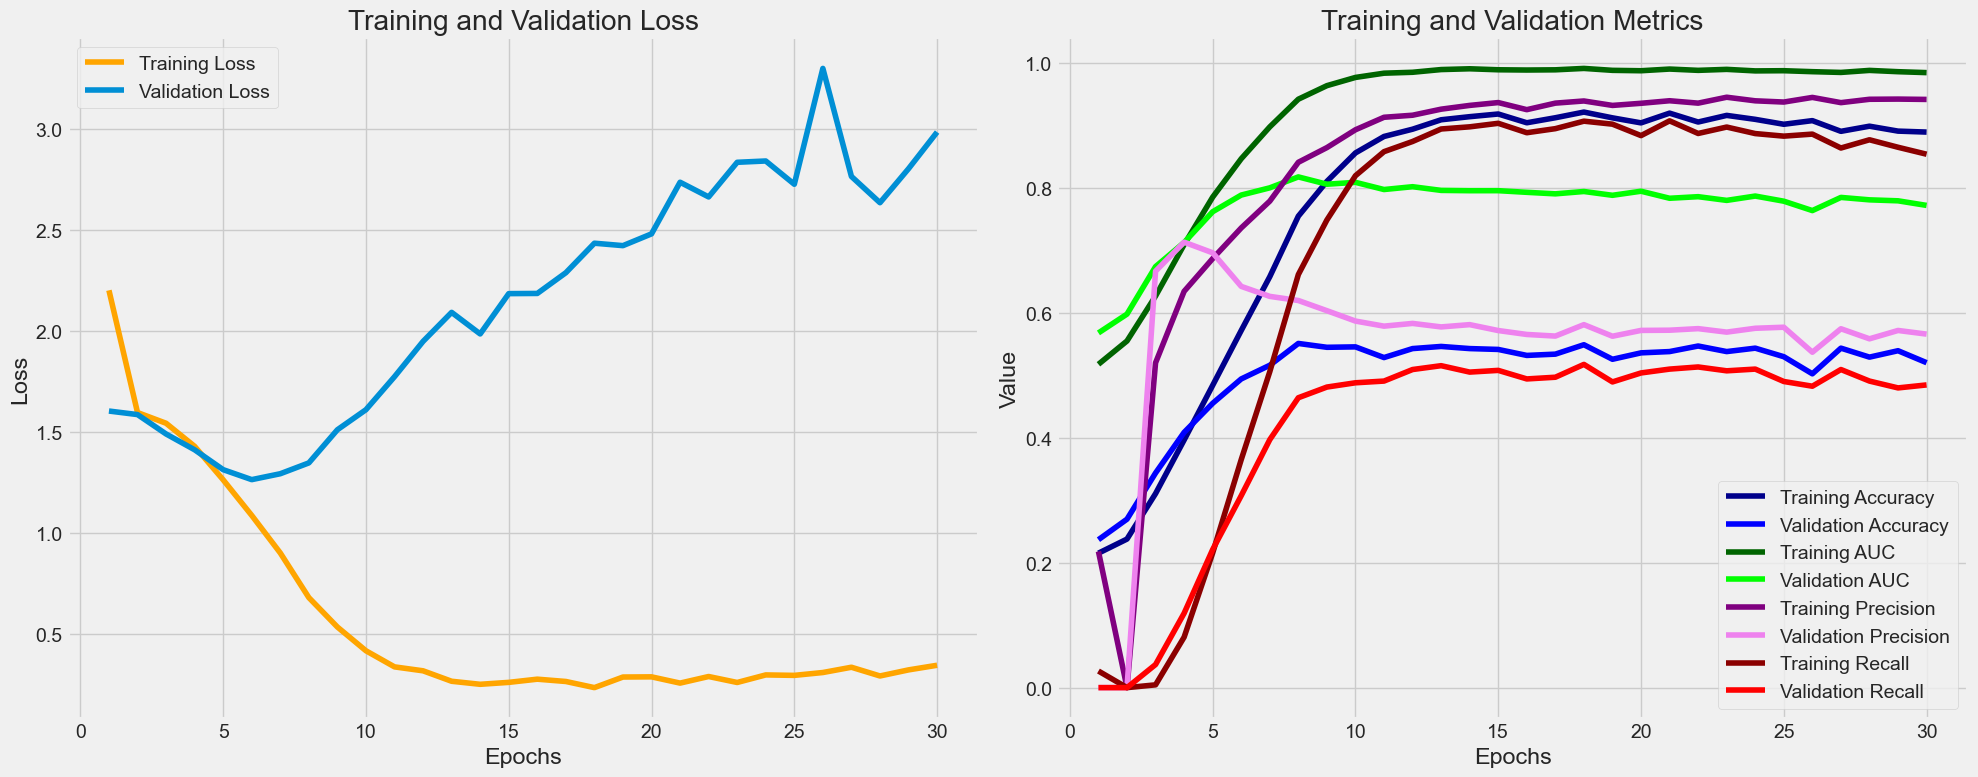

12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 362ms/step
Matriz de confusión guardada en: model_base_CNN_TODO_matrix_confusion_matrix.png


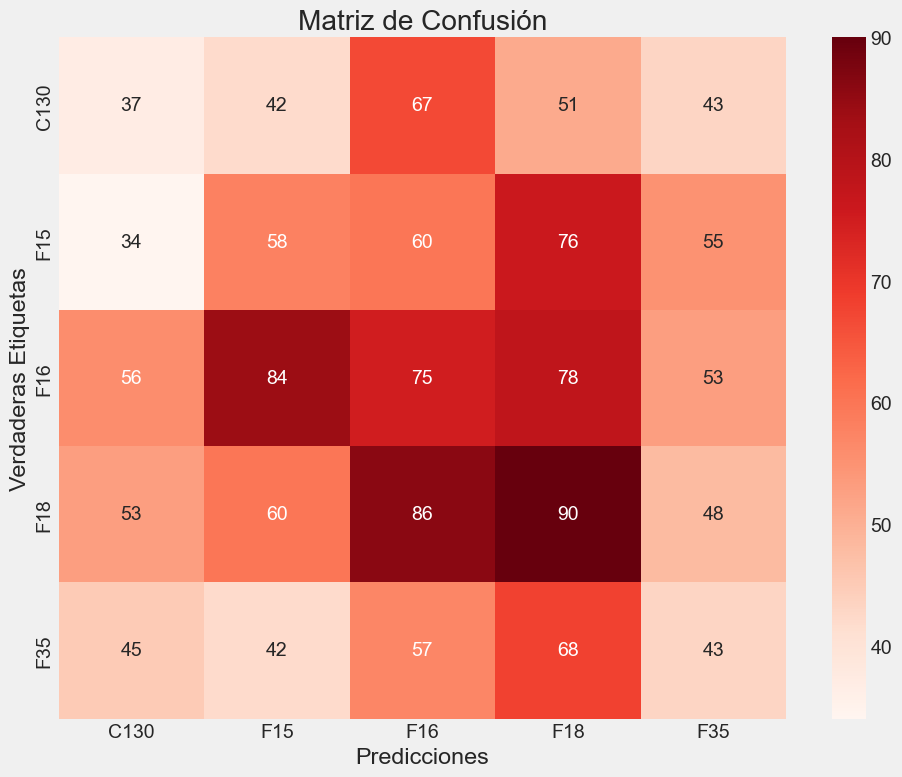

Reporte de Clasificación:
              precision    recall  f1-score   support

        C130       0.16      0.15      0.16       240
         F15       0.20      0.20      0.20       283
         F16       0.22      0.22      0.22       346
         F18       0.25      0.27      0.26       337
         F35       0.18      0.17      0.17       255

    accuracy                           0.21      1461
   macro avg       0.20      0.20      0.20      1461
weighted avg       0.21      0.21      0.21      1461

Reporte de clasificación guardado en: model_base_CNN_TODO_matrix_classification_report.txt


In [62]:
# Compilación del modelo
model_base_CNN_TODO.compile(optimizer="adam",
                       loss="categorical_crossentropy",
                       metrics=['accuracy','precision','recall','auc'])

# Entrenamiento del modelo
history = model_base_CNN_TODO.fit(
    train_generator,
    epochs=30,
    validation_data=test_generator
)

#Guardar metrica
all_metrics["model_base_CNN_TODO"] = history.history

plot_training_history(history, "model_base_CNN_TODO")

# Suponiendo que tienes las etiquetas verdaderas y las predicciones del modelo
y_true = test_generator.classes  # Etiquetas verdaderas del conjunto de validación
y_pred = model_base_CNN_TODO.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convertir probabilidades a clases

# Nombres de las clases
class_names = list(test_generator.class_indices.keys())

# Llamada a la función
plot_confusion_matrix_and_classification_report(y_true, y_pred_classes, class_names, "model_base_CNN_TODO_matrix")

In [63]:
model_base_CNN_MAXPOLLIG = tf.keras.models.Sequential([
    Conv2D(32, (3,3), activation = "relu", input_shape= (32, 32, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),
    Conv2D(64, (3,3), activation = "relu", input_shape= (32, 32, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),
    Conv2D(128, (3,3), activation = "relu", input_shape= (32, 32, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(256, activation = "relu"),
    Dropout(0.2),
    Dense(128, activation = "relu"),
    Dropout(0.2),
    Dense(n_classes ,activation="softmax")
])

model_base_CNN_MAXPOLLIG.summary()

/Users/daniel/.pyenv/versions/3.10.13/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_14 (Flatten)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 258,117 (1008.27 KB)

 Trainable params: 258,117 (1008.27 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 24s 489ms/step - accuracy: 0.2258 - auc: 0.5336 - loss: 1.6105 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.2375 - val_auc: 0.5785 - val_loss: 1.5880 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 22s 475ms/step - accuracy: 0.2421 - auc: 0.5629 - loss: 1.5894 - precision: 0.0833 - recall: 8.8650e-05 - val_accuracy: 0.2813 - val_auc: 0.6257 - val_loss: 1.5507 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 23s 497ms/step - accuracy: 0.2826 - auc: 0.6079 - loss: 1.5603 - precision: 0.3942 - recall: 0.0010 - val_accuracy: 0.3066 - val_auc: 0.6472 - val_loss: 1.5139 - val_precision: 0.2857 - val_recall: 0.0014
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 22s 490ms/step - accuracy: 0.3283 - auc: 0.6485 - loss: 1.5163 - precision: 0.5780 - recall: 0.0112 - val_accuracy: 0.3511 - val_auc: 0.6772 - val_loss: 1.4914 - val_precision: 0.6557 - val_recall: 0.0274


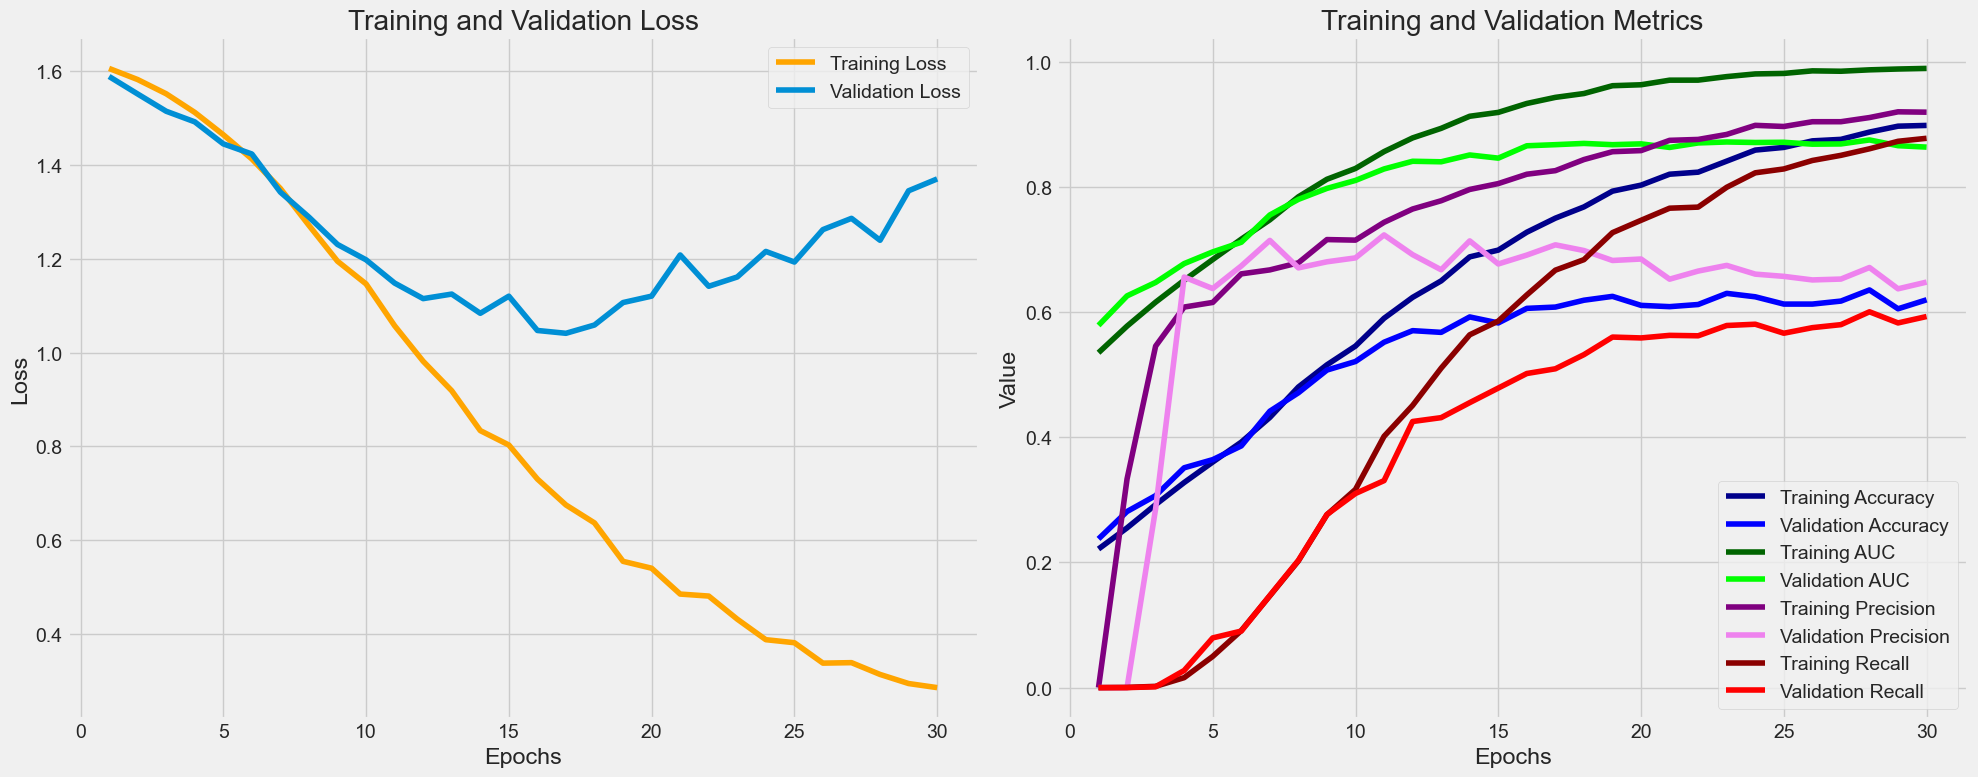

12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 366ms/step
Matriz de confusión guardada en: model_base_CNN_MAXPOLLIGmatrix_confusion_matrix.png


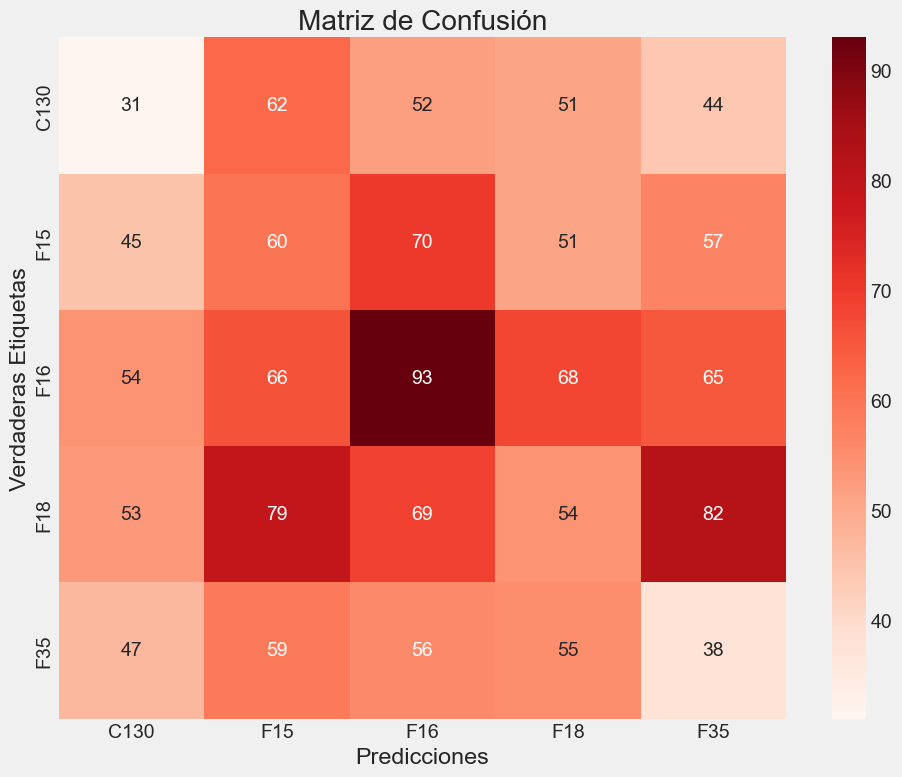

Reporte de Clasificación:
              precision    recall  f1-score   support

        C130       0.13      0.13      0.13       240
         F15       0.18      0.21      0.20       283
         F16       0.27      0.27      0.27       346
         F18       0.19      0.16      0.18       337
         F35       0.13      0.15      0.14       255

    accuracy                           0.19      1461
   macro avg       0.18      0.18      0.18      1461
weighted avg       0.19      0.19      0.19      1461

Reporte de clasificación guardado en: model_base_CNN_MAXPOLLIGmatrix_classification_report.txt


In [64]:
model_base_CNN_MAXPOLLIG.compile(optimizer="adam",
                       loss="categorical_crossentropy",
                       metrics=['accuracy','precision','recall','auc'])

# Entrenamiento del modelo
history = model_base_CNN_MAXPOLLIG.fit(
    train_generator,
    epochs=30,
    validation_data=test_generator
)

#Guardar metrica
all_metrics["model_base_CNN_MAXPOLLIG"] = history.history

plot_training_history(history, "model_base_CNN_MAXPOLLIG")

# Suponiendo que tienes las etiquetas verdaderas y las predicciones del modelo
y_true = test_generator.classes  # Etiquetas verdaderas del conjunto de validación
y_pred = model_base_CNN_MAXPOLLIG.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convertir probabilidades a clases

# Nombres de las clases
class_names = list(test_generator.class_indices.keys())

# Llamada a la función
plot_confusion_matrix_and_classification_report(y_true, y_pred_classes, class_names, "model_base_CNN_MAXPOLLIGmatrix")

################################
**MODELO CNN V2**
################################

In [65]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers

model_base_CNN_2 = tf.keras.models.Sequential([
    Input(shape=(32, 32, 3)),
    
    Conv2D(32, (3, 3), activation="relu", kernel_regularizer=regularizers.l2(1e-4), padding="same"),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),

    Conv2D(64, (3, 3), activation="relu", kernel_regularizer=regularizers.l2(1e-4), padding="same"),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),

    Conv2D(128, (3, 3), activation="relu", kernel_regularizer=regularizers.l2(1e-4), padding="same"),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),

    Flatten(),
    Dense(256, activation="relu"),
    Dropout(0.5),
    Dense(128, activation="relu"),
    Dropout(0.5),

    # Capa de salida
    Dense(n_classes, activation="softmax")
])


model_base_CNN_2.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_11 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_15 (Flatten)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 651,333 (2.48 MB)

 Trainable params: 651,333 (2.48 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 24s 505ms/step - accuracy: 0.2134 - auc: 0.5129 - loss: 1.6365 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.2389 - val_auc: 0.5521 - val_loss: 1.6166 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 22s 485ms/step - accuracy: 0.2193 - auc: 0.5388 - loss: 1.6150 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.2402 - val_auc: 0.5831 - val_loss: 1.5974 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 22s 487ms/step - accuracy: 0.2324 - auc: 0.5610 - loss: 1.6056 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.2437 - val_auc: 0.5860 - val_loss: 1.5994 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 23s 494ms/step - accuracy: 0.2579 - auc: 0.5769 - loss: 1.5932 - precision: 0.0841 - recall: 1.9281e-04 - val_accuracy: 0.2444 - val_auc: 0.5755 - val_loss: 1.6009 - val_precision: 0.00

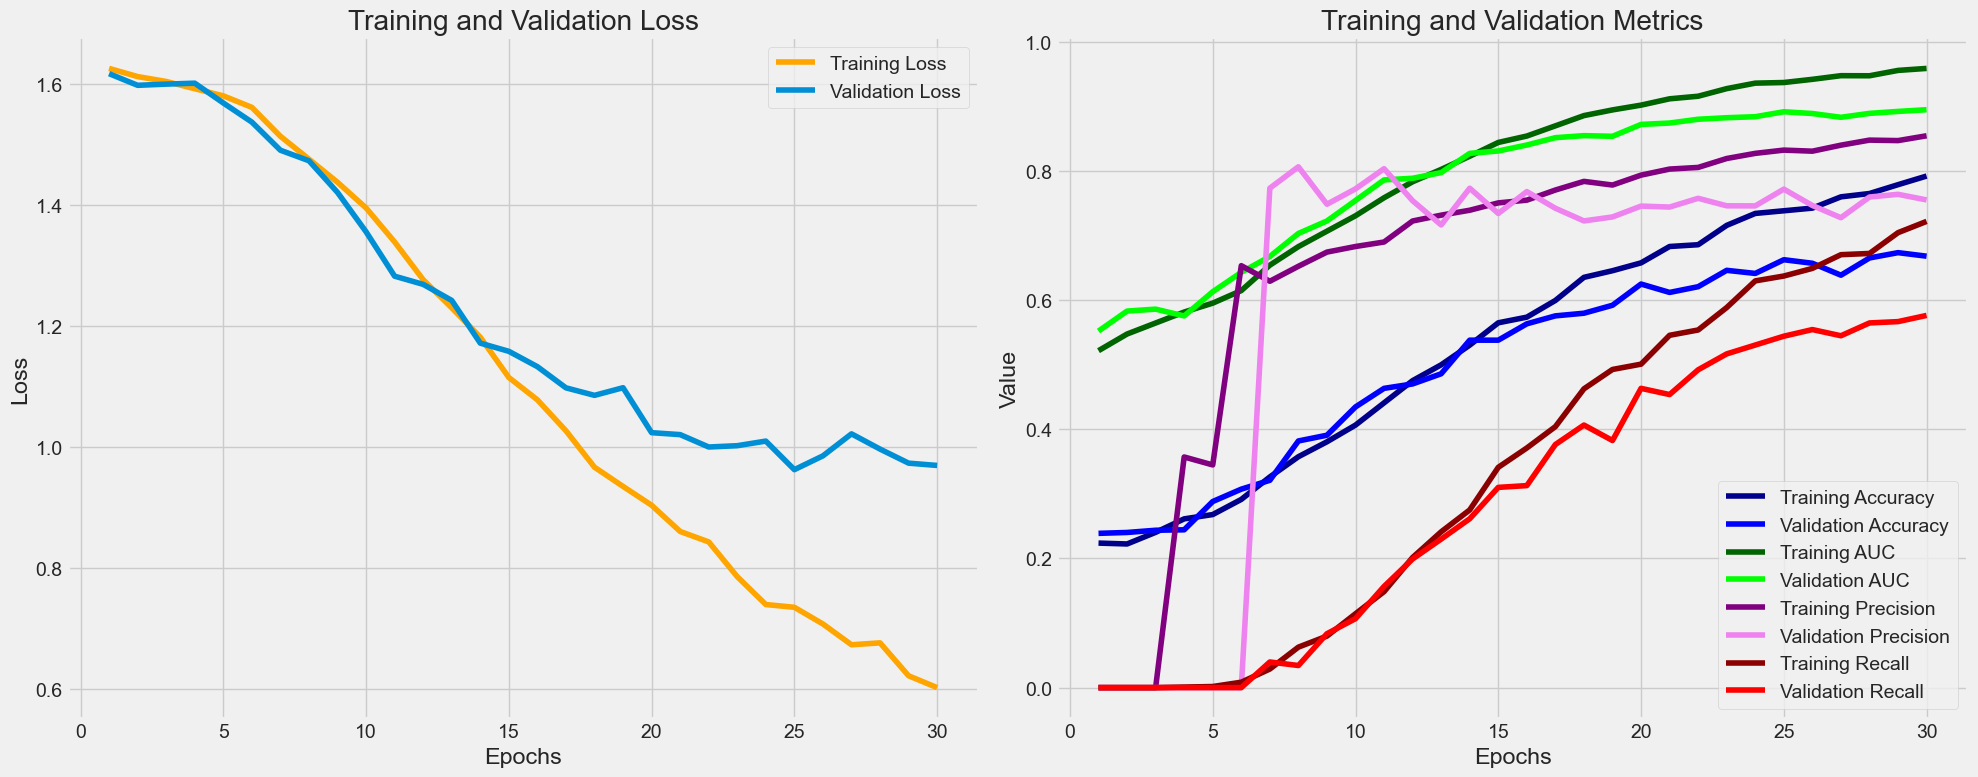

46/46 ━━━━━━━━━━━━━━━━━━━━ 18s 386ms/step
Matriz de confusión guardada en: model_base_CNN_2_matrix_confusion_matrix.png


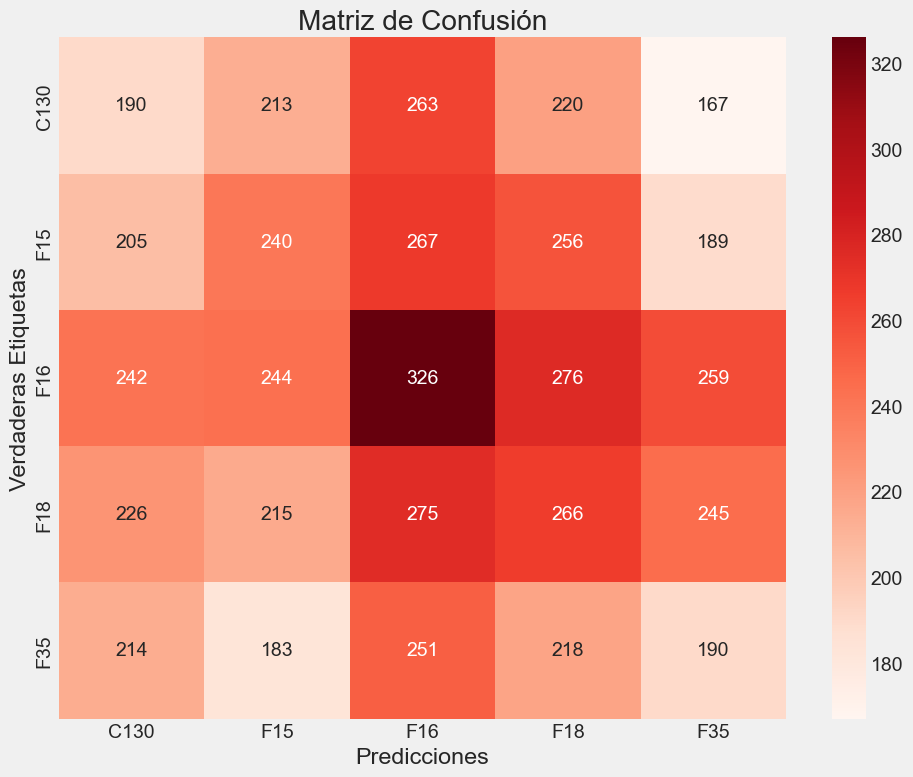

Reporte de Clasificación:
              precision    recall  f1-score   support

        C130       0.18      0.18      0.18      1053
         F15       0.22      0.21      0.21      1157
         F16       0.24      0.24      0.24      1347
         F18       0.22      0.22      0.22      1227
         F35       0.18      0.18      0.18      1056

    accuracy                           0.21      5840
   macro avg       0.21      0.21      0.21      5840
weighted avg       0.21      0.21      0.21      5840

Reporte de clasificación guardado en: model_base_CNN_2_matrix_classification_report.txt


In [66]:
model_base_CNN_2.compile(optimizer="adam",
                       loss="categorical_crossentropy",
                       metrics=['accuracy','precision','recall','auc'])

# Entrenamiento del modelo
history = model_base_CNN_2.fit(
    train_generator,
    epochs=30,
    validation_data=test_generator
)

#Guardar metrica
all_metrics["model_base_CNN_2"] = history.history

plot_training_history(history, "model_base_CNN_2")

# Suponiendo que tienes las etiquetas verdaderas y las predicciones del modelo
y_true = train_generator.classes  # Etiquetas verdaderas del conjunto de validación
y_pred = model_base_CNN_2.predict(train_generator)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convertir probabilidades a clases

# Nombres de las clases
class_names = list(train_generator.class_indices.keys())

# Llamada a la función
plot_confusion_matrix_and_classification_report(y_true, y_pred_classes, class_names, "model_base_CNN_2_matrix")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


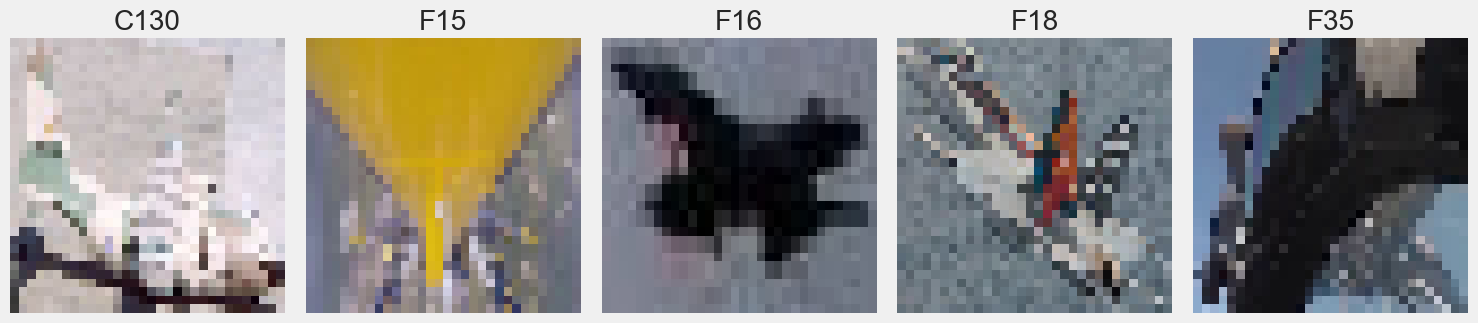

In [88]:
# Crear un diccionario para almacenar un ejemplo por clase
examples_per_class = {class_name: None for class_name in class_names}

# Iterar sobre el conjunto de prueba
for images, _ in test_generator:
    predictions = np.argmax(model_base_CNN_2.predict(images), axis=1)  # Predicciones del modelo
    for i, pred in enumerate(predictions):
        class_name = class_names[pred]
        if examples_per_class[class_name] is None:
            examples_per_class[class_name] = images[i]  # Guardar la imagen para esa clase
    if all(value is not None for value in examples_per_class.values()):  # Verifica que todos los valores no sean None
  # Si ya hay un ejemplo por clase, detener la búsqueda
        break

# Visualizar ejemplos por clase
fig, axes = plt.subplots(1, len(class_names), figsize=(15, 5))

for i, class_name in enumerate(class_names):
    ax = axes[i]
    ax.imshow(examples_per_class[class_name].squeeze(), cmap='gray')  # Usar 'gray' para imágenes en escala de grises
    ax.axis("off")
    ax.set_title(class_name)

plt.tight_layout()
plt.show()

In [70]:
# Materializar datos del generador
def generator_to_numpy(generator):
    images, labels = [], []
    for i in range(len(generator)):
        batch = generator[i]
        images.append(batch[0])
        labels.append(batch[1])
    return np.concatenate(images), np.concatenate(labels)

# Convertir generadores
train_data, train_labels = generator_to_numpy(train_generator)

from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
import numpy as np

# Configuración
cv = 5
kf = KFold(n_splits=cv)
fold_scores = []

# Validación cruzada
for train_index, val_index in kf.split(train_data):
    X_train, X_val = train_data[train_index], train_data[val_index]
    y_train, y_val = train_labels[train_index], train_labels[val_index]

    # Entrenar el modelo con los datos de entrenamiento
    model_base_CNN_2.fit(X_train, y_train, epochs=5, verbose=0)  # Ajusta los epochs según sea necesario

    # Evaluar el modelo con los datos de validación
    y_pred = np.argmax(model_base_CNN_2.predict(X_val), axis=1)
    y_val_true = np.argmax(y_val, axis=1)

    accuracy = accuracy_score(y_val_true, y_pred)
    fold_scores.append(accuracy)

# Resultados de la validación cruzada
print("Scores por fold:", fold_scores)
print("Media del score:", np.mean(fold_scores))
print("Desviación estándar del score:", np.std(fold_scores))


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Scores por fold: [0.7988013698630136, 0.8972602739726028, 0.934931506849315, 0.9666095890410958, 0.9726027397260274]
Media del score: 0.9140410958904109
Desviación estándar del score: 0.06354700985884683


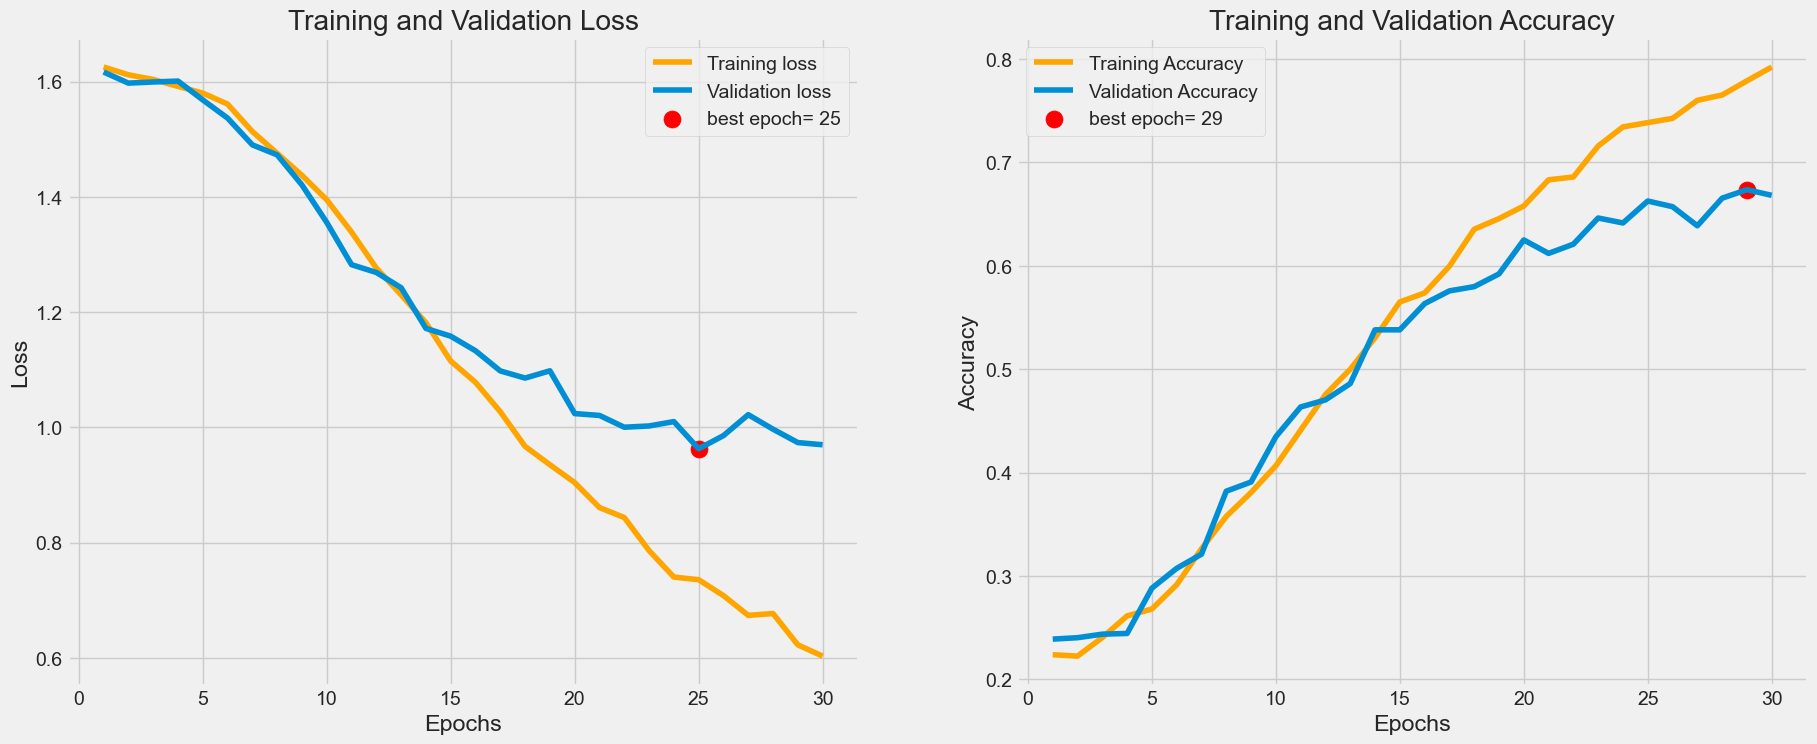

In [71]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
    
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'
    
Epochs = [i+1 for i in range(len(tr_acc))]
    
    # Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')
    
plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'orange', label= 'Training loss')
plt.plot(Epochs, val_loss, label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'red', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'orange', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'red', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

################################
**MODEL TRANSFER LEARNING V1**
################################

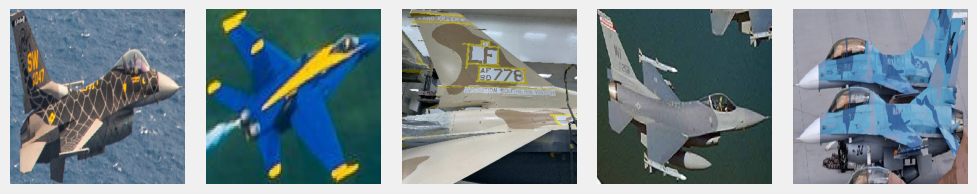

In [79]:
# Generador de entrenamiento
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepaths',
    y_col='labels',
    target_size=(299, 299),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=128,
    subset="training"
)


# Generador de prueba (test)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepaths',
    y_col='labels',
    target_size=(299, 299),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=128
)

Found 5840 validated image filenames belonging to 5 classes.
Found 1461 validated image filenames belonging to 5 classes.


In [80]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [81]:
pre_trained_model = InceptionV3(
    include_top = False,
    input_tensor = tf.keras.layers.Input(shape = (299, 299, 3))
)

for layer in pre_trained_model.layers:
  layer.trainable = False

In [82]:
last_layers= pre_trained_model.get_layer("mixed7")
last_output = last_layers.output

x = tf.keras.layers.Flatten()(last_output)
x = tf.keras.layers.Dense(128, activation = "relu")(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(data_dir['labels'].nunique(), activation= "softmax")(x)

model_keras = tf.keras.Model(pre_trained_model.input, x)

model_keras.compile(optimizer= "adam", loss = "categorical_crossentropy", metrics=['accuracy','precision','recall','auc'])

In [83]:
history = model_keras.fit(
    train_generator,
    epochs = 30,
    validation_data = test_generator,
)

/Users/daniel/.pyenv/versions/3.10.13/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30


/Users/daniel/.pyenv/versions/3.10.13/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_662']. Received: the structure of inputs=*
  warnings.warn(


46/46 ━━━━━━━━━━━━━━━━━━━━ 48s 972ms/step - accuracy: 0.2623 - auc: 0.5611 - loss: 5.4818 - precision: 0.2676 - recall: 0.1403 - val_accuracy: 0.4339 - val_auc: 0.7878 - val_loss: 2.3962 - val_precision: 0.6286 - val_recall: 0.1355
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 39s 827ms/step - accuracy: 0.5086 - auc: 0.8254 - loss: 1.1258 - precision: 0.7750 - recall: 0.2893 - val_accuracy: 0.6968 - val_auc: 0.9037 - val_loss: 1.6564 - val_precision: 0.8608 - val_recall: 0.5079
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 38s 819ms/step - accuracy: 0.7450 - auc: 0.9447 - loss: 0.6710 - precision: 0.8605 - recall: 0.6562 - val_accuracy: 0.7584 - val_auc: 0.9290 - val_loss: 1.4967 - val_precision: 0.8478 - val_recall: 0.6598
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 38s 816ms/step - accuracy: 0.8224 - auc: 0.9711 - loss: 0.4882 - precision: 0.9113 - recall: 0.7691 - val_accuracy: 0.7892 - val_auc: 0.9393 - val_loss: 1.6137 - val_precision: 0.8716 - val_recall: 0.6920
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 4

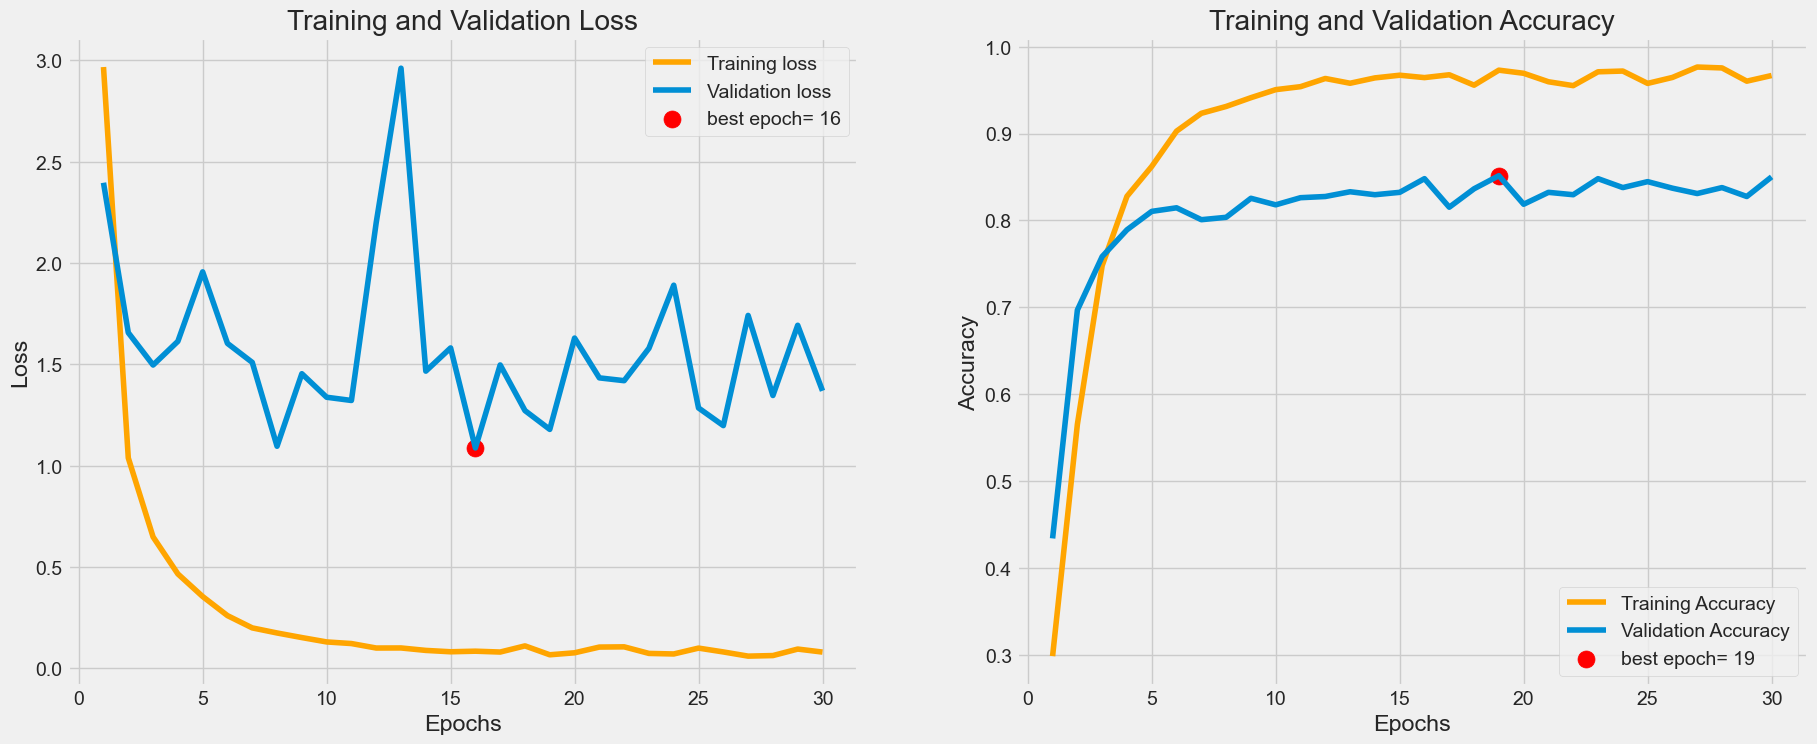

In [84]:

tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
    
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'
    
Epochs = [i+1 for i in range(len(tr_acc))]
    
    # Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')
    
plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'orange', label= 'Training loss')
plt.plot(Epochs, val_loss, label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'red', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'orange', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'red', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

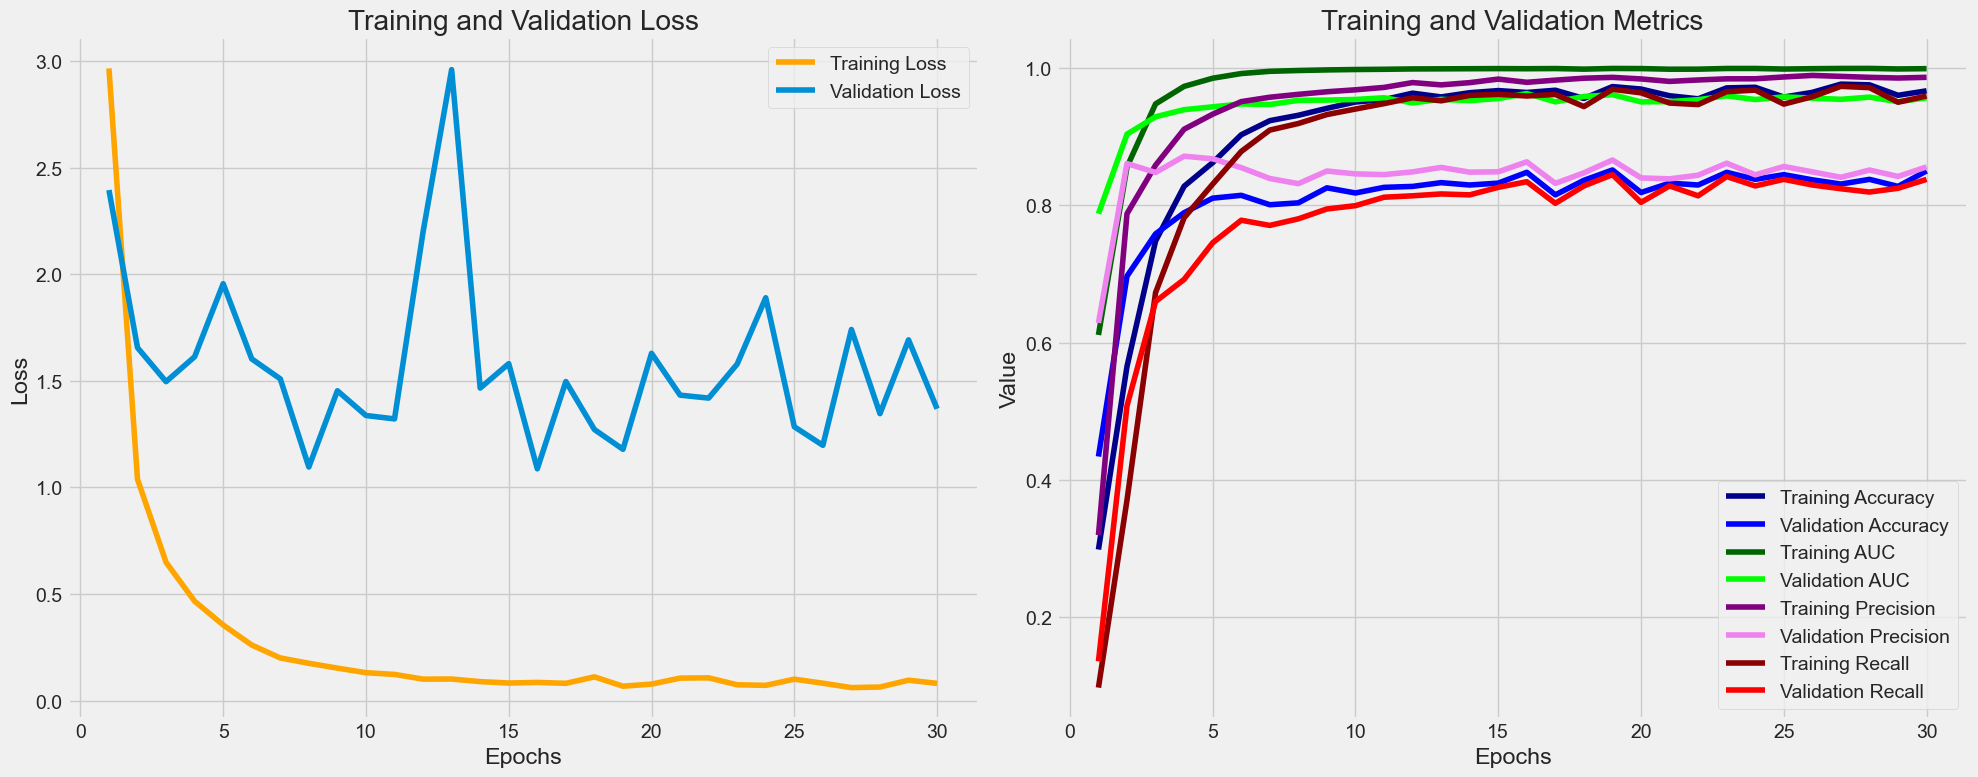

12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 607ms/step
Matriz de confusión guardada en: model_inceptionV3_matrix_confusion_matrix.png


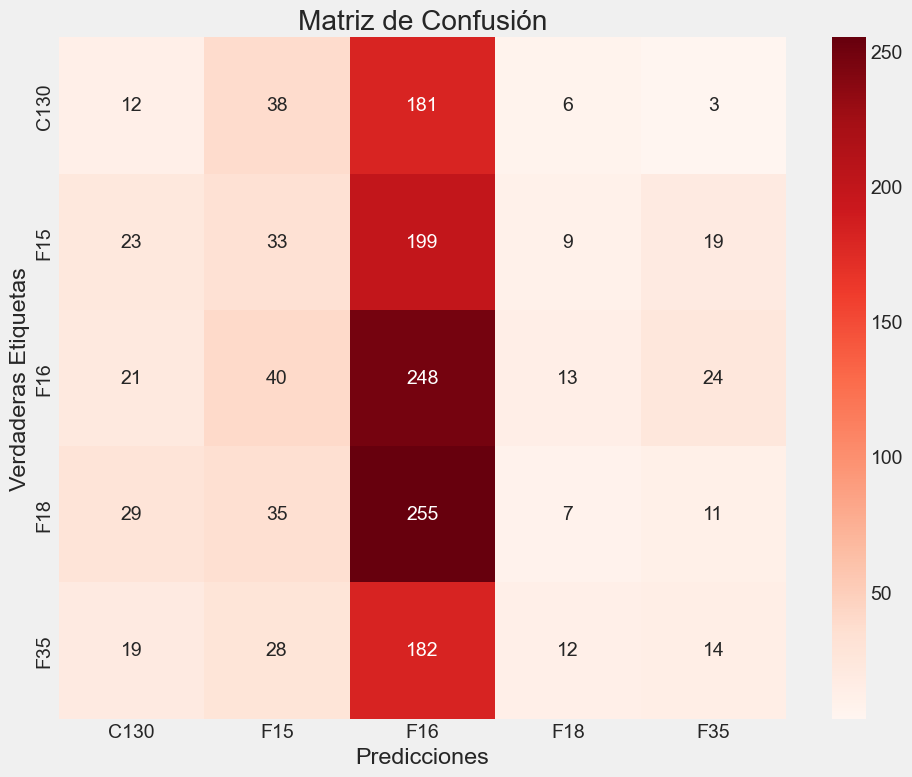

Reporte de Clasificación:
              precision    recall  f1-score   support

        C130       0.12      0.05      0.07       240
         F15       0.19      0.12      0.14       283
         F16       0.23      0.72      0.35       346
         F18       0.15      0.02      0.04       337
         F35       0.20      0.05      0.09       255

    accuracy                           0.21      1461
   macro avg       0.18      0.19      0.14      1461
weighted avg       0.18      0.21      0.15      1461

Reporte de clasificación guardado en: model_inceptionV3_matrix_classification_report.txt


In [87]:
all_metrics["model_inceptionV3"] = history.history

plot_training_history(history, "model_inceptionV3")

# Suponiendo que tienes las etiquetas verdaderas y las predicciones del modelo
y_true = test_generator.classes  # Etiquetas verdaderas del conjunto de validación
y_pred = model_keras.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convertir probabilidades a clases

# Nombres de las clases
class_names = list(train_generator.class_indices.keys())

# Llamada a la función
plot_confusion_matrix_and_classification_report(y_true, y_pred_classes, class_names, "model_inceptionV3_matrix")

In [85]:
# Generar predicciones en el conjunto de prueba
predictions = model_keras.evaluate(test_generator)


12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 625ms/step - accuracy: 0.2793 - auc: 0.5697 - loss: 1.5606 - precision: 0.8817 - recall: 0.0284


################################
**MODEL TRANSFER LEARNING V2**
################################

In [91]:
# Create Model Structure
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras import regularizers


img_size = (299, 299)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_generator.class_indices.keys())) # to define number of classes in dense layer

# create pre-trained model (you can built on pretrained model such as :  efficientnet, VGG , Resnet )
# we will use efficientnetb3 from EfficientNet family.
base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')

model = tf.keras.models.Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics=['accuracy','precision','recall','auc'])

model.summary()


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)     │ (None, 1536)           │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_261         │ (None, 1536)           │         6,144 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 256)            │       393,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,184,436 (42.67 MB)

 Trainable params: 11,094,061 (42.32 MB)

 Non-trainable params: 90,375 (353.03 KB)

In [ ]:
history = model.fit(
    train_generator,
    epochs = 20,
    validation_data = test_generator,
)

Epoch 1/20


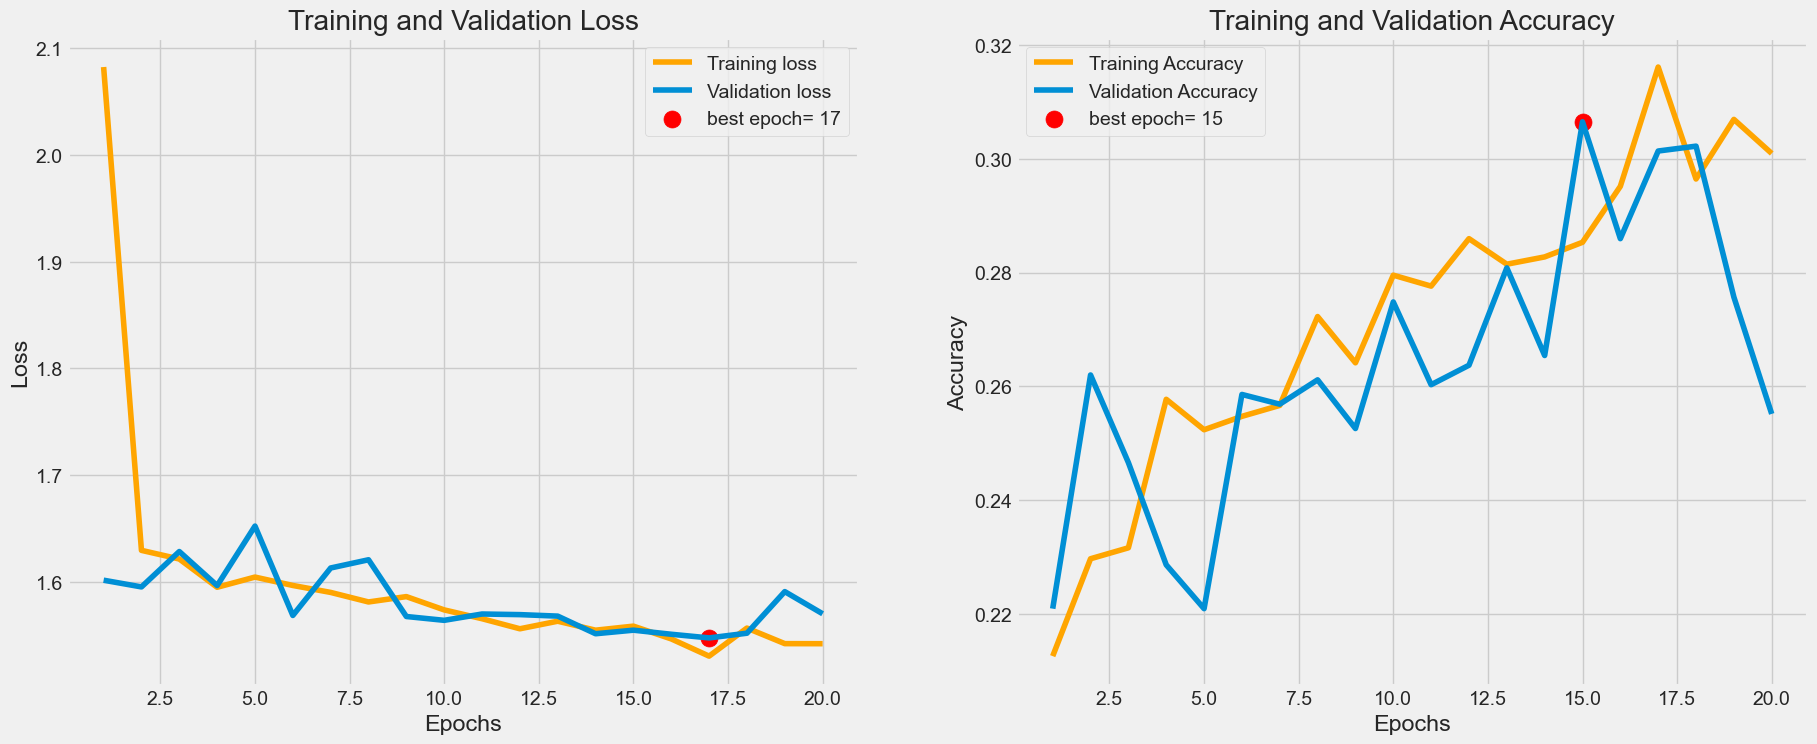

In [29]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
    
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'
    
Epochs = [i+1 for i in range(len(tr_acc))]
    
    # Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')
    
plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'orange', label= 'Training loss')
plt.plot(Epochs, val_loss, label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'red', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'orange', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'red', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [30]:
predictions = model_keras.evaluate(test_generator_resize)


10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 570ms/step - accuracy: 0.3910 - loss: 3.5361


10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step 


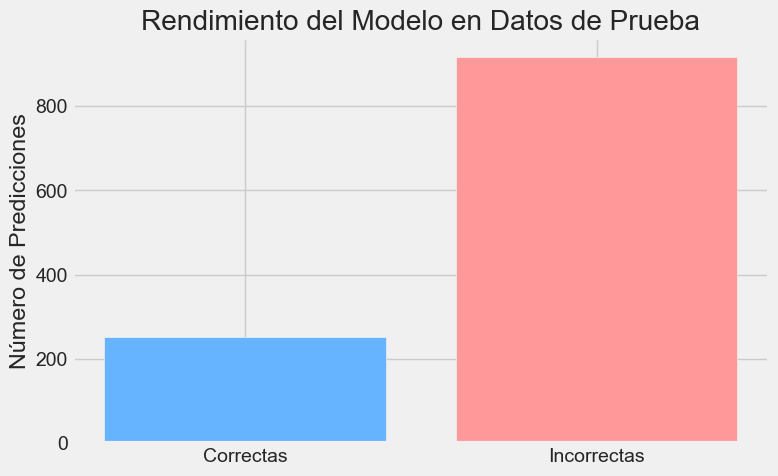

In [31]:
# Generar predicciones en el conjunto de prueba
predictions = model.predict(test_generator_resize)
predicted_classes = np.argmax(predictions, axis=1) if predictions.ndim > 1 else (predictions > 0.5).astype(int)
true_classes = test_generator_resize.classes  # Obtener las etiquetas verdaderas

# Calcular número de aciertos y errores
correct_predictions = np.sum(predicted_classes == true_classes)
incorrect_predictions = np.sum(predicted_classes != true_classes)

# Crear la gráfica
plt.figure(figsize=(8, 5))
plt.bar(['Correctas', 'Incorrectas'], [correct_predictions, incorrect_predictions], color=['#66b3ff', '#ff9999'])
plt.title("Rendimiento del Modelo en Datos de Prueba")
plt.ylabel("Número de Predicciones")
plt.show()

In [32]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split


# Cargar imágenes
def load_images(filepaths):
    images = []
    for path in filepaths:
        img = image.load_img(path, target_size=(299, 299))  # Ajusta el tamaño si es necesario
        img_array = image.img_to_array(img)
        images.append(img_array)
    return np.array(images)

# Cargar x_train y x_test
x = load_images(data_dir['filepaths'].values)

# Dividir en entrenamiento y prueba (si no tienes datos separados)
x_train, x_test = train_test_split(x, test_size=0.2, random_state=42)

# Normalizar
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# Aplanar para DNN autoencoder
x_train_flatten = x_train.reshape(len(x_train), np.prod(x_train.shape[1:]))
x_test_flatten = x_test.reshape(len(x_test), np.prod(x_test.shape[1:]))

print(x_train_flatten[0].shape)  # Verificar la forma después de aplanar

(268203,)


In [33]:
import tensorflow as tf

# Definir la dimensión de codificación
encoding_dimension = 64

# Encoder
input_img = tf.keras.layers.Input(shape=(299, 299, 3))  # Para imágenes RGB de 299x299

# Aplanar las imágenes para pasarlas a través de las capas densas
flattened = tf.keras.layers.Flatten()(input_img)

# Embebido
encoded = tf.keras.layers.Dense(encoding_dimension, activation='relu')(flattened)

# Decodificación
decoded = tf.keras.layers.Dense(299 * 299 * 3, activation='sigmoid')(encoded)

# Redimensionar la salida de nuevo al tamaño de imagen
decoded_reshaped = tf.keras.layers.Reshape((299, 299, 3))(decoded)

# Crear el autoencoder
autoencoder = tf.keras.models.Model(input_img, decoded_reshaped)
autoencoder.summary()

# Optimización
opt = tf.optimizers.Adam(learning_rate=0.01)
autoencoder.compile(optimizer=opt, loss='binary_crossentropy')

# Ajuste del modelo
autoencoder.fit(x_train, x_train, epochs=10,
                batch_size=256, shuffle=True,
                validation_data=(x_test, x_test))

# Encoder
encoder = tf.keras.models.Model(input_img, encoded)

# Decoder
encoded_input = tf.keras.layers.Input(shape=(encoding_dimension,))
decoder_layer = autoencoder.layers[-2]  # La capa de decodificación antes de Reshape
decoder = tf.keras.models.Model(encoded_input, decoder_layer(encoded_input))

print("\n Encoder model: encoder \n")
print(encoder.summary())
print("\n Decoder model: decoder \n")
print(decoder.summary())


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 268203)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │    17,165,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 268203)         │    17,433,195 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 299, 299, 3)    │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,598,251 (131.98 MB)

 Trainable params: 34,598,251 (131.98 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - loss: 0.6778 - val_loss: 0.6947
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 20s 803ms/step - loss: 0.6040 - val_loss: 0.7032
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 20s 799ms/step - loss: 0.5303 - val_loss: 0.7187
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 20s 805ms/step - loss: 0.4644 - val_loss: 0.7401
Epoch 5/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 20s 808ms/step - loss: 0.4072 - val_loss: 0.7663
Epoch 6/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 20s 805ms/step - loss: 0.3581 - val_loss: 0.7959
Epoch 7/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 20s 805ms/step - loss: 0.3162 - val_loss: 0.8279
Epoch 8/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 20s 808ms/step - loss: 0.2805 - val_loss: 0.8616
Epoch 9/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 20s 814ms/step - loss: 0.2501 - val_loss: 0.8963
Epoch 10/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 20s 813ms/step - loss: 0.2240 - val_loss: 0.9314

 Encoder model: encoder 



Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 268203)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │    17,165,056 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,165,056 (65.48 MB)

 Trainable params: 17,165,056 (65.48 MB)

 Non-trainable params: 0 (0.00 B)

None

 Decoder model: decoder 



Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 268203)         │    17,433,195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,433,195 (66.50 MB)

 Trainable params: 17,433,195 (66.50 MB)

 Non-trainable params: 0 (0.00 B)

None


46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


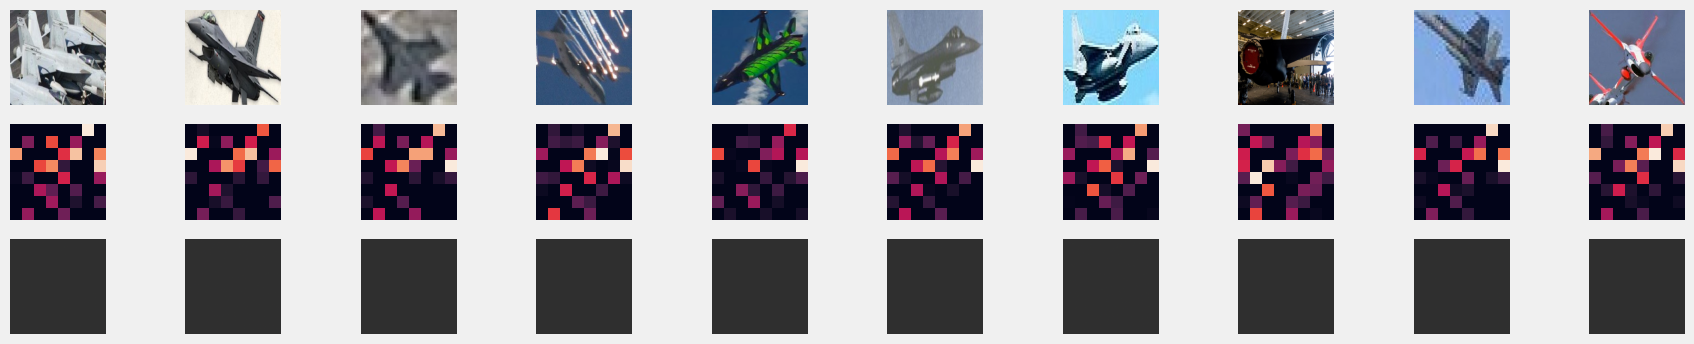

In [34]:
# Realizar las predicciones
encoded_imgs = encoder.predict(x_test)
predicted = autoencoder.predict(x_test)

# Visualizar los resultados
plt.figure(figsize=(40, 4))
for i in range(10):
    # Mostrar imagen original
    ax = plt.subplot(3, 20, i + 1)
    plt.imshow(x_test[i])  # Imagen original (299, 299, 3)
    plt.axis('off')  # Desactivar los ejes

    # Mostrar imagen codificada
    ax = plt.subplot(3, 20, i + 1 + 20)
    plt.imshow(encoded_imgs[i].reshape(8, 8))  # Imagen codificada (dimensión de codificación: 64, reshape a 8x8)
    plt.axis('off')  # Desactivar los ejes

    # Mostrar imagen reconstruida
    ax = plt.subplot(3, 20, 2 * 20 + i + 1)
    plt.imshow(predicted[i].reshape(299, 299, 3))  # Reconstrucción (tamaño de la imagen original)
    plt.axis('off')  # Desactivar los ejes

plt.show()